# Оценка качества моделей (Decision Trees, Linear Regression) на анализе данных Dataset Boston из библиотеки sklearn.

Проведем небольшое исследование. Будем измерять качество моделей Decision Tree и Linear Regression на данных датасета Boston.

## Quality metrics (метрики качества)
В связи с тем, что в датасете целевая переменная - это стоимость жилья в зависимости от некоторых факторов, то нашей задачей по прогнозированию целевой переменной является задача регрессии. В таком случае, логично определить в качестве основной метрики качества - **standard deviation (среднекватратичное отклонение)**.

## Quality assessment space (пространство для оценки качества)
Качество мы будем замерять как на обучающей выборке, так и на тестовой. Подходы для формирования обучающей и тестовой выборки:
1) простое разделение в соотношение 70 на 30
2) разделение 70 на 30 с кросс-валидацией на 10 фолдов

Фиксировать результаты оценок лучших моделей будем в таблицы.

## Модели, с помощью которых мы будем строить прогноз:
### Decision Trees:
#### Gradient Boosting:

1) GB Regression (sklearn)
###### *Parametres*:
*a) Step length*

*b) Tree depth*

*c) Number of trees*

*d) Feature coverage percent*

*e) Percentage of objects*

*f) Stochastic descend*
#### Random Forest:
1) Random Forest Regressor (sklearn)
###### Parametres:
*a) Tree depth*

*b) Number of trees*

*c) Feature coverage percent*

*d) Percentage of objects*

### Linear Model:
#### Linear Regression:
1) Analitical Solution

2) LinearRegression (sklearn)

3) Ridge (sklearn)

4) Lasso (sklearn)

###### Parametres:
*a) Step length*

*b) Number of steps*

*c) Regularization L1*

*d) Regularization L2*

*e) ElasticNet (sklearn)*

*f) Polynomial Features*

## Часть 2. Оценки на масштабированных признаках

# Импортируем библиотеки

In [1]:
from sklearn import datasets, model_selection, tree, metrics, ensemble, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

# Dataset Boston

In [2]:
boston = datasets.load_boston()

Преобразуем данные датасета в формат pandas для того, чтобы удобнее было визуально ознакомится с данными

In [3]:
# занесем данные датасета в таблицу
boston_table = pd.DataFrame(boston.data)

# переименнуем заголовки таблицы в соответствии с их обозначениями
# 1. Создадим словарь названий столбцов признаков
columns = {}

for i in range(13):
    col_i = {i:boston.feature_names[i]}
    columns.update(col_i)

# 2. Переименуем столбцы признаков
boston_table.rename(columns=columns, inplace=True)

# 3. Занесем в таблицу столбец целевых значений
boston_table['Target: MEDV'] = boston.target

boston_table.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target: MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Двигаемся дальше. 
# Переведем данные в формат numpy.
Так удобнее будет их обрабатывать.

In [4]:
# переведем в массив numpy признаки
x_data = np.array(boston_table[boston_table.columns[:-1]])
x_data.shape

(506L, 13L)

In [5]:
# переведем в массив numpy целевой признак
y = np.array(boston_table[boston_table.columns[-1]])
print y.shape
y = y.reshape(x_data.shape[0], 1)
print y.shape

(506L,)
(506L, 1L)


# Разобьем выборку на обучающую и тестовую
Разбивать будем в соотношении 70 на 30 с использованием псевдослучайного отбора объектов (опция по умолчанию).

На тестовой выборке качество будем замерять при кросс-валидации на 10 фолдов

In [6]:
# разобьем выборку
(x_train, x_test, y_train, y_test) = model_selection.train_test_split(x_data, y, random_state = 1, test_size = 0.3)

# Масштабирование признаков 

In [7]:
scale = preprocessing.StandardScaler()

x_train_scale = scale.fit_transform(x_train)

x_test_scale = scale.transform(x_test)

In [8]:
x_train = x_train_scale

x_test = x_test_scale

# Напишем функции

Для каждой модели мы будем менять параметры и по параметрам будем замерять качество. Результаты будут записываться в таблицы. Одна таблица для оценок на кросс-валидации, одна таблица для оценки качества на тестовой выборке без кросс-валидации.

Давайте напишем функции оценки качества моделей в зависимости от передаваемых параметров:

1) оценки на кросс-валидации

2) оценки на выборке без разделения на подвыборки

In [9]:
# укажем количество знаков округления результата оценки
decimal = 3
# укажем количество фолдов
cv = 10

# функция оценки качества модели на КРОСС-ВАЛИДАЦИИ
def make_df_cv(model_fit, x_test, y_test, cv, decimal):
    mse_cv = model_selection.cross_val_score(
        model_fit, x_test, y_test, scoring = 'neg_mean_squared_error', cv = cv)
    mse_cv = map(lambda x: round((-x)**0.5, decimal), mse_cv)
    mse_cv.append(round(np.mean(mse_cv), decimal))
    return mse_cv

# функция оценки качества модели на тестовой выборке без разделения на подвыборки
def make_df_noncv(model_fit, x_test, y_test, decimal):
    y_predict = model_fit.predict(x_test)
    mse_noncv = round((metrics.mean_squared_error(y_test, y_predict))**0.5,decimal)
    return [mse_noncv]

Напишем функции вывода на экран таблиц:

1) Таблица оценок качества модели на кросс-валидации 

2) Таблица оценок качества модели на тестовой выборке без применения кросс-валидации

In [10]:
def print_dataframe_cv(name_model, dataframe_cv, cv):
    print 'Model quality assessment on CV (%s folds) \nModel: %s' % (cv, name_model)
    return dataframe_cv

def print_dataframe_noncv(name_model, dataframe_noncv, cv):
    print 'Model quality assessment NONCV \n' 'Model:', name_model
    return dataframe_noncv

Напишем функцию для отрисовки графиков. Визуализируем оценки качества моделей

In [11]:
# в функцию на вход подаются таблицы pandas, в которых зафиксированы результаты оценки качества модели
def graph_for_quality(cv_table, non_cv_table, name_model):
    # визуализируем результаты тестирования модели с применением кросс-валидации
    # для этого воспользуемся средствами визуализации pandas 
    # (так как series не имеет возможности строить boxplot, то мы приделаем в этот раз костыли)
    print 'Model quality assessment \n' 'Model:', name_model 
    for_box_plot = pd.DataFrame(cv_table[:-1])
    for_box_plot.boxplot(figsize=(24,14))

    n = 0
    for i in cv_table.columns:
        n = n + 1

    x = np.array(range(1, n+1)).reshape(n)
    y = np.array(cv_table[-1:]).reshape(n)

    plt.plot(x, y, 'o', color = 'orange', markersize = 12, label = 'Mean quality with CV')

    x = np.array(range(1, n+1)).reshape(n)
    y = np.array(non_cv_table).reshape(n)

    plt.plot(x, y, 'o', color = 'red', markersize = 12, label = 'Quality without CV')


    plt.xlabel('Parametres', size = 18)
    plt.ylabel('Quality', size = 18)
    plt.legend(prop={'size': 20})
    plt.title('Graph: Boxplot CV model quality range, CV model quality range average, model quality without CV', size = 24)
    plt.show()

Создадим таблицу лучших моделей

Напишем функцию добавления оценок качества с таблицу лучших моделей и вывода текущей таблицы на экран

In [12]:
best_models_dataframe_cv = pd.DataFrame()

def upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model):
    best_idx_model = dataframe_cv[-1:].idxmin(axis = 1)
    best_models_dataframe_cv[name_model] = (np.array(dataframe_cv[best_idx_model])).reshape(cv+1)
    print 'Quality assessment of the best models dataframe'
    return best_models_dataframe_cv

Создадим таблицу standard deviation 
Напишем функцию, которая будет:

1) определять стандартное отклонение лучшей модели

2) сохранять результат в таблицу

3) выводить таблицу на экран

In [13]:
dataframe_std = pd.DataFrame()

def make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model):
    dataframe_std[name_model] = [round(best_models_dataframe_cv[name_model].std(axis = 0),decimal)]
    print 'Стандартное отклонение оценок качества лучших моделей на кросс-валидации:'
    return dataframe_std

In [14]:
best_models_dataframe_noncv = pd.DataFrame()

def upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model):
    best_idx_model = dataframe_noncv[-1:].idxmin(axis = 1)
    best_models_dataframe_noncv[name_model] = (np.array(dataframe_noncv[best_idx_model])).reshape(1)
    print 'Quality assessment of the best models dataframe'
    return best_models_dataframe_noncv

Переходим собственно к анализу. Анализ на масштабированных данных проведен во второй части работы

# Decision Trees: Gradient Boosting
## Handmade function

## Gradient Boosting Regressor

### Без использования случайного выбора признаков

Зададим имя модели, создадим пустые dataframes, укажем параметры, которые будет перебирать для нахождения лучших оценок качества, посчитаем качество

In [15]:
name_model = 'GBR'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_trees = [1, 10, 50, 100, 250, 500]
list_depth = [1, 3, 5, 7, 10]

for tree in list_trees:
    for depth in list_depth:
        params = (tree, depth)
        model = ensemble.GradientBoostingRegressor(
            learning_rate = 0.01, max_depth = depth, n_estimators = tree, random_state = 1)
        model_fit = model.fit(x_train, y_train)
        dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
        dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

C:\Users\Alexander\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Выведем на печать оценки качества модели

In [16]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: GBR


,"(1, 1)","(1, 3)","(1, 5)","(1, 7)","(1, 10)","(10, 1)","(10, 3)","(10, 5)","(10, 7)","(10, 10)",...,"(250, 1)","(250, 3)","(250, 5)","(250, 7)","(250, 10)","(500, 1)","(500, 3)","(500, 5)","(500, 7)","(500, 10)"
0,4.363,4.351,4.352,4.343,4.340,4.347,4.225,4.211,4.167,4.103,...,3.857,3.391,3.069,3.071,3.427,3.785,3.118,2.948,3.052,3.528
1,10.814,10.796,10.776,10.775,10.779,10.299,10.073,9.963,9.971,9.979,...,4.304,2.854,2.875,3.104,2.931,2.980,2.363,2.518,2.743,2.568
2,12.553,12.518,12.530,12.524,12.521,11.938,11.605,11.654,11.635,11.581,...,5.283,4.142,4.260,4.314,4.498,4.414,3.913,3.859,3.995,4.242
3,9.741,9.706,9.693,9.687,9.687,9.319,8.985,8.955,8.887,8.862,...,4.661,4.765,4.748,4.911,4.926,3.661,4.501,4.815,5.171,5.166
4,10.832,10.814,10.808,10.817,10.805,10.322,10.175,10.147,10.113,10.103,...,6.086,5.318,5.526,6.180,6.389,5.773,4.903,5.249,6.116,6.482
5,9.452,9.437,9.434,9.440,9.438,8.801,8.650,8.616,8.645,8.661,...,3.720,3.197,2.942,2.583,2.695,3.106,3.188,3.110,2.618,2.714
6,9.535,9.492,9.485,9.488,9.484,9.155,8.753,8.682,8.719,8.712,...,4.516,3.352,3.164,3.478,4.193,3.250,3.081,3.044,3.527,4.406
7,11.917,11.912,11.914,11.925,11.910,10.993,10.963,11.015,11.009,10.973,...,4.727,4.271,4.249,4.205,4.314,4.323,4.103,4.046,4.171,4.325
8,5.827,5.814,5.806,5.809,5.808,5.545,5.407,5.347,5.371,5.373,...,2.942,1.911,1.935,1.938,2.078,2.452,1.709,1.868,1.866,2.073
9,7.540,7.513,7.512,7.517,7.525,7.082,6.813,6.840,6.849,6.855,...,3.220,2.936,3.152,3.203,2.954,3.174,3.066,3.419,3.491,3.197


Выведем на печать оценки качества модели без разделения тестовой выборки на подвыборки

In [17]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: GBR


,"(1, 1)","(1, 3)","(1, 5)","(1, 7)","(1, 10)","(10, 1)","(10, 3)","(10, 5)","(10, 7)","(10, 10)",...,"(250, 1)","(250, 3)","(250, 5)","(250, 7)","(250, 10)","(500, 1)","(500, 3)","(500, 5)","(500, 7)","(500, 10)"
0,9.555,9.52,9.512,9.509,9.511,9.23,8.919,8.803,8.804,8.794,...,5.067,3.285,3.16,3.093,3.647,4.19,2.796,2.889,2.889,3.547


Посмотрим на график зачений

Model quality assessment 
Model: GBR


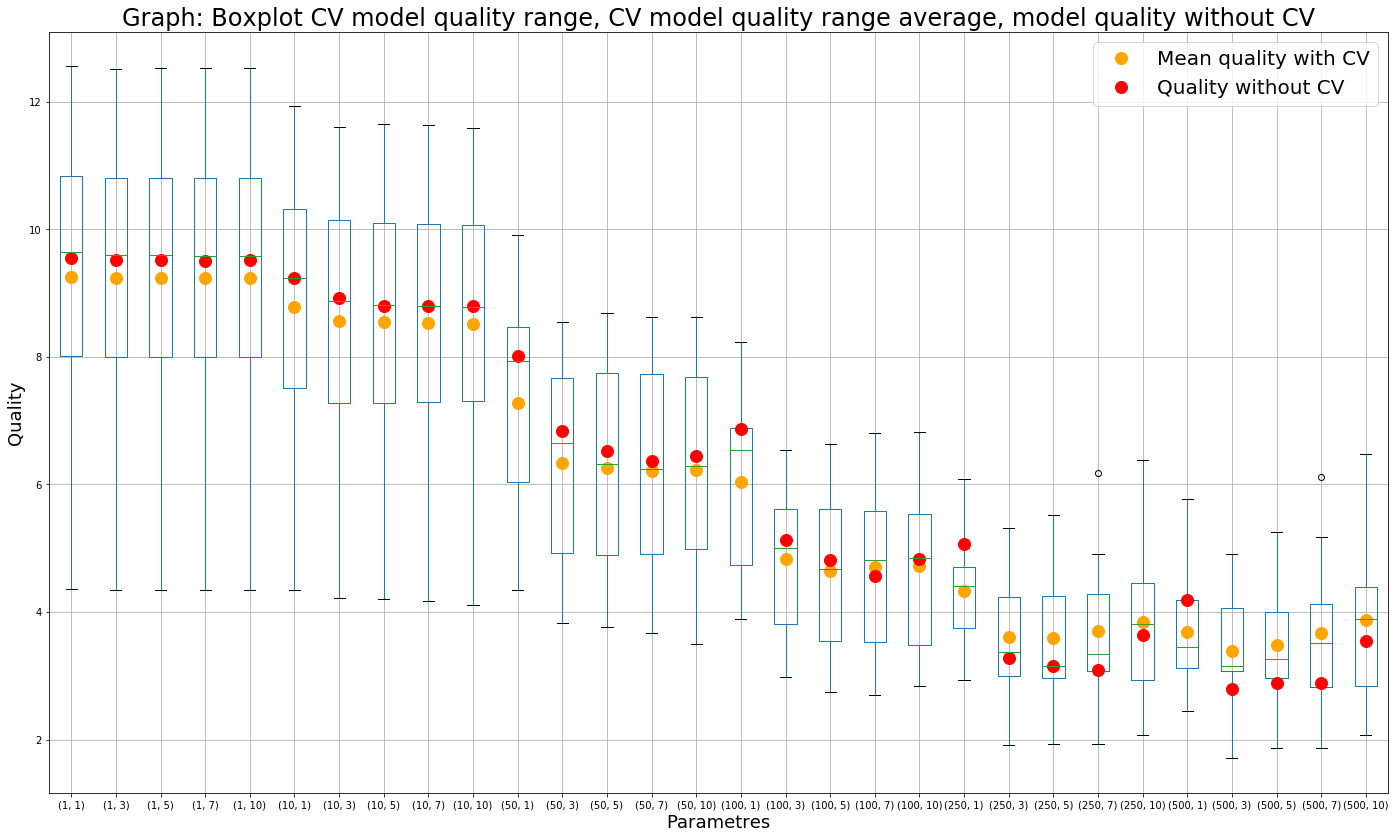

In [18]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Итак, мы наблюдаем следующее:

1) С увеличением роста деревьев, качество модели постоянно растет, хотя разница в результатах между моделью, использующей 250 и 500 деревьев уже не такая существенная, как например разница при использовании 10 и 50 деревьев.

2) С увеличением глубины каждого дерева до 3 или 5 качество модели улучшается, далее качество падает. Похоже на переобучение. Можно проверить на обучающей и тестовой выборке.

Давайте посмотрим будет ли изменяться качество при увеличении количества деревьев. Изменим параметры.

In [19]:
name_model = 'GBR'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_trees = [500, 1000, 1500, 2500]
list_depth = [3, 4]

for tree in list_trees:
    for depth in list_depth:
        params = (tree, depth)
        model = ensemble.GradientBoostingRegressor(
            learning_rate = 0.01, max_depth = depth, n_estimators = tree, random_state = 1)
        model_fit = model.fit(x_train, y_train)
        dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
        dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [20]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: GBR


,"(500, 3)","(500, 4)","(1000, 3)","(1000, 4)","(1500, 3)","(1500, 4)","(2500, 3)","(2500, 4)"
0,3.118,3.005,3.031,2.933,3.025,2.913,2.927,2.914
1,2.363,2.418,2.234,2.361,2.241,2.343,2.229,2.371
2,3.913,3.908,3.894,3.885,3.903,3.879,3.903,3.900
3,4.501,5.079,4.508,5.061,4.568,5.062,4.560,5.052
4,4.903,5.260,4.639,5.123,4.575,5.068,4.522,5.053
5,3.188,3.065,3.179,3.107,3.174,3.102,3.242,3.104
6,3.081,2.844,2.974,2.804,2.988,2.819,2.990,2.830
7,4.103,3.672,4.067,3.643,4.071,3.644,4.048,3.651
8,1.709,1.791,1.711,1.811,1.709,1.802,1.743,1.805
9,3.066,3.311,3.139,3.488,3.147,3.501,3.175,3.495


In [21]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: GBR


,"(500, 3)","(500, 4)","(1000, 3)","(1000, 4)","(1500, 3)","(1500, 4)","(2500, 3)","(2500, 4)"
0,2.796,2.895,2.665,2.806,2.671,2.817,2.699,2.814


Model quality assessment 
Model: GBR


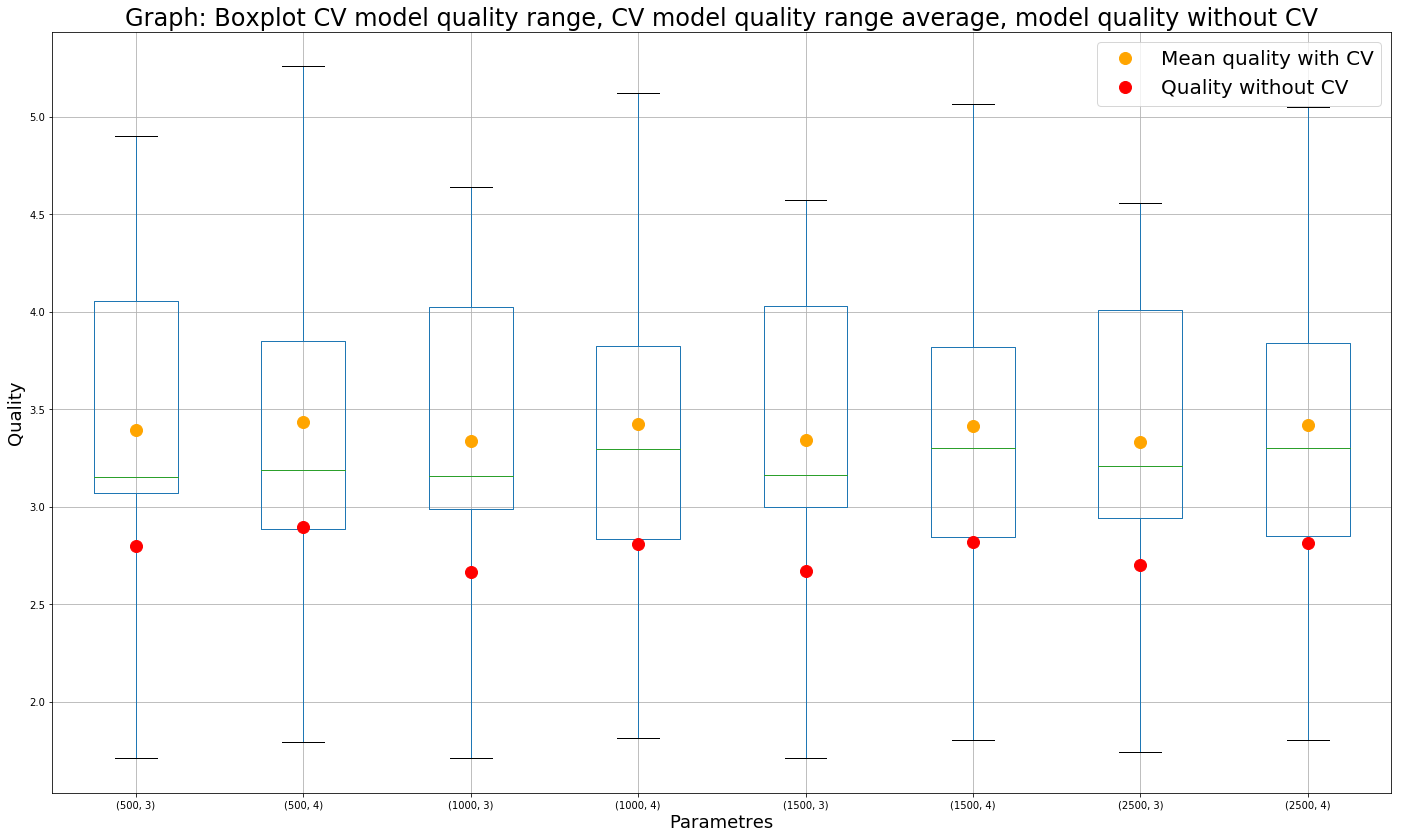

In [22]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Увеличение деревьев более 500 не принесло заметного увеличения качества.

При кросс-валидации лучшие параметры: 2500 деревьев с глубиной 3

Без применения кросс-валидации лучшие параметры: 1000 деревьев с глубиной 3.

Запишем результаты в таблицу

In [23]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR
0,2.927
1,2.229
2,3.903
3,4.560
4,4.522
5,3.242
6,2.990
7,4.048
8,1.743
9,3.175


Посчитаем и запишем стандартное отклонение

In [24]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR
0,0.884


Запишем оценку качества лучшей модели (без разделения на подвыборки) 

In [25]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR
0,2.665


### При построении каждого дерева отбираем признаки: max_features = 'sqrt'

In [26]:
name_model = 'GBR_sqrt'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_trees = [1, 10, 50, 100, 250, 500]
list_depth = [1, 3, 5, 7, 10]

for tree in list_trees:
    for depth in list_depth:
        params = (tree, depth)
        model = ensemble.GradientBoostingRegressor(
            learning_rate = 0.01, max_depth = depth, n_estimators = tree, max_features = 'sqrt', random_state = 1)
        model_fit = model.fit(x_train, y_train)
        dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
        dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [27]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: GBR_sqrt


,"(1, 1)","(1, 3)","(1, 5)","(1, 7)","(1, 10)","(10, 1)","(10, 3)","(10, 5)","(10, 7)","(10, 10)",...,"(250, 1)","(250, 3)","(250, 5)","(250, 7)","(250, 10)","(500, 1)","(500, 3)","(500, 5)","(500, 7)","(500, 10)"
0,4.363,4.365,4.368,4.356,4.353,4.195,4.232,4.232,4.206,4.171,...,4.403,4.058,3.416,3.272,3.268,4.567,3.852,3.321,3.290,3.312
1,10.814,10.785,10.794,10.782,10.800,10.400,10.097,10.084,10.029,10.041,...,5.729,3.663,3.262,3.149,3.196,4.176,2.797,2.617,2.642,2.788
2,12.553,12.532,12.529,12.535,12.551,12.082,11.775,11.760,11.804,11.872,...,6.845,5.683,5.493,5.972,5.953,5.495,5.166,4.990,5.485,5.471
3,9.741,9.717,9.712,9.728,9.698,9.384,9.086,9.030,9.044,9.027,...,5.309,3.806,3.563,3.326,3.392,4.194,3.197,3.100,2.955,3.075
4,10.832,10.821,10.822,10.797,10.815,10.438,10.273,10.231,10.102,10.129,...,7.183,5.639,5.870,6.079,5.986,6.666,5.268,5.706,5.960,5.929
5,9.452,9.450,9.445,9.454,9.440,8.961,8.839,8.818,8.860,8.799,...,4.643,3.112,3.099,3.135,3.226,3.584,2.723,2.898,2.886,2.944
6,9.535,9.509,9.491,9.496,9.499,9.175,8.888,8.834,8.769,8.794,...,4.488,2.735,2.623,2.477,2.567,3.045,2.287,2.380,2.277,2.390
7,11.917,11.923,11.912,11.920,11.932,11.326,11.092,11.040,10.950,11.027,...,5.284,3.726,3.353,3.454,3.494,4.289,3.542,3.267,3.403,3.418
8,5.827,5.808,5.812,5.799,5.811,5.526,5.454,5.431,5.354,5.385,...,2.901,2.153,1.920,1.857,1.997,2.767,1.892,1.671,1.677,1.819
9,7.540,7.539,7.506,7.551,7.527,7.148,7.007,6.996,6.939,6.893,...,3.053,2.295,2.237,2.302,2.262,2.202,2.114,2.135,2.181,2.074


In [28]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: GBR_sqrt


,"(1, 1)","(1, 3)","(1, 5)","(1, 7)","(1, 10)","(10, 1)","(10, 3)","(10, 5)","(10, 7)","(10, 10)",...,"(250, 1)","(250, 3)","(250, 5)","(250, 7)","(250, 10)","(500, 1)","(500, 3)","(500, 5)","(500, 7)","(500, 10)"
0,9.553,9.529,9.533,9.515,9.515,9.241,9.026,8.945,8.883,8.857,...,5.552,3.766,3.369,3.297,3.338,4.401,3.037,2.937,2.956,3.045


Model quality assessment 
Model: GBR_sqrt


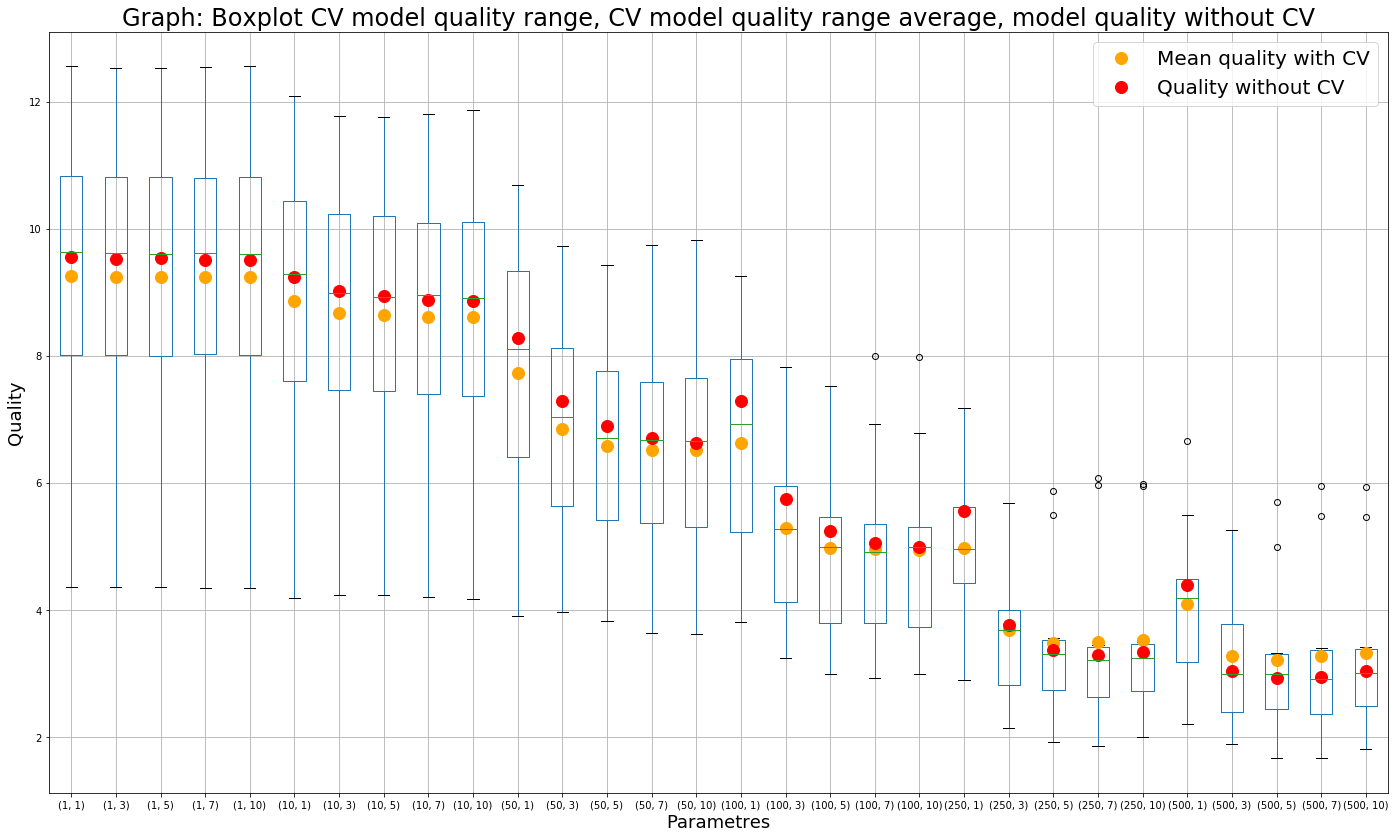

In [29]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Принципиально случайный отбор признаков при каждом новом дереве не изменил качество модели. Однако есть некотороые отличия. Давайте посмотрим на них внимтельнее.

1) На 500 деревьях при увеличении глубины дерева до 10 переобучения не произошло. Возможно это просто случайность???

2) Если посмотреть на разброс значений при кросс-валидации, это видно даже по графикам - он здесь несколько ниже. Но это справедливо только в случае, большой глубины дерева: 7 и 10. Для глубины равной 3 - разброс примерно одинаков.

В связи с тем, что мы наблюдаем улучшение качества модели при увеличении количества деревьев, предлагается провести дополнительные исследования.

In [30]:
name_model = 'GBR_sqrt'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_trees = [500, 1000, 1500, 2500]
list_depth = [3, 4]

for tree in list_trees:
    for depth in list_depth:
        params = (tree, depth)
        model = ensemble.GradientBoostingRegressor(
            learning_rate = 0.01, max_depth = depth, n_estimators = tree, max_features = 'sqrt', random_state = 1)
        model_fit = model.fit(x_train, y_train)
        dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
        dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [31]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: GBR_sqrt


,"(500, 3)","(500, 4)","(1000, 3)","(1000, 4)","(1500, 3)","(1500, 4)","(2500, 3)","(2500, 4)"
0,3.852,3.434,3.684,3.349,3.613,3.323,3.536,3.292
1,2.797,2.673,2.362,2.465,2.257,2.424,2.197,2.403
2,5.166,5.097,5.138,5.094,5.165,5.118,5.188,5.129
3,3.197,3.198,2.997,3.069,2.939,3.033,2.900,3.018
4,5.268,5.338,5.023,5.237,4.953,5.197,4.930,5.173
5,2.723,2.789,2.703,2.784,2.779,2.804,2.823,2.811
6,2.287,2.268,2.280,2.279,2.306,2.282,2.326,2.299
7,3.542,3.574,3.570,3.586,3.549,3.557,3.485,3.537
8,1.892,1.647,1.763,1.635,1.728,1.652,1.753,1.662
9,2.114,2.125,2.223,2.221,2.315,2.249,2.404,2.274


In [32]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: GBR_sqrt


,"(500, 3)","(500, 4)","(1000, 3)","(1000, 4)","(1500, 3)","(1500, 4)","(2500, 3)","(2500, 4)"
0,3.037,2.918,2.816,2.815,2.779,2.829,2.779,2.832


Model quality assessment 
Model: GBR_sqrt


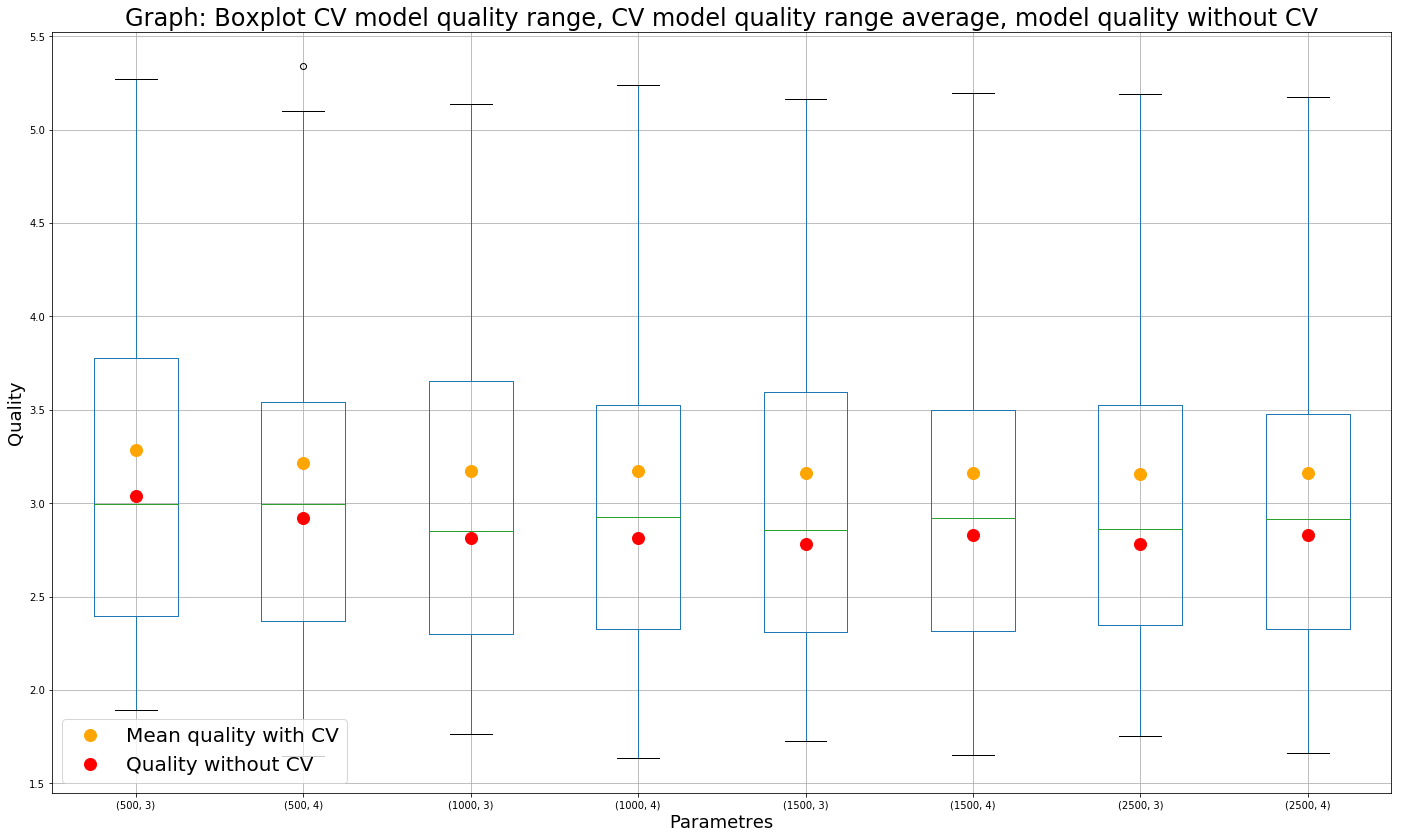

In [33]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Увеличение деревьев более чем 500 не принесло заметного увеличения качества, также как и в прошлый раз. Однако можно заметить, что при использовании всех признаков модель склонна переобучаться при большой глубине, тогда как в модели, использующей признаки псевдослучайными образом, изменение глубины дерева не сильно влияет на переобучение. И тем не менее, переобучение имеется.

При кросс-валидации лучшие параметры: 2500 деревьев с глубиной 3

Без применения кросс-валидации лучшие параметры: 2500 деревьев с глубиной 3.

Запишем результаты в таблицу

In [34]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt
0,2.927,3.536
1,2.229,2.197
2,3.903,5.188
3,4.560,2.900
4,4.522,4.930
5,3.242,2.823
6,2.990,2.326
7,4.048,3.485
8,1.743,1.753
9,3.175,2.404


In [35]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt
0,0.884,1.088


In [36]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt
0,2.665,2.779


### Стохастический градиентный бустинг

In [37]:
name_model = 'GBR_stoch'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_trees = [500, 1500, 2500]
list_depth = [3, 5]
list_subsamples = [0.7, 0.8, 0.9]


for subsample in list_subsamples:
    for tree in list_trees:
        for depth in list_depth:
            params = (subsample, tree, depth)
            model = ensemble.GradientBoostingRegressor(
                learning_rate = 0.01, max_depth = depth, n_estimators = tree, subsample = subsample, random_state = 1)
            model_fit = model.fit(x_train, y_train)
            dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
            dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [38]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: GBR_stoch


,"(0.7, 500, 3)","(0.7, 500, 5)","(0.7, 1500, 3)","(0.7, 1500, 5)","(0.7, 2500, 3)","(0.7, 2500, 5)","(0.8, 500, 3)","(0.8, 500, 5)","(0.8, 1500, 3)","(0.8, 1500, 5)","(0.8, 2500, 3)","(0.8, 2500, 5)","(0.9, 500, 3)","(0.9, 500, 5)","(0.9, 1500, 3)","(0.9, 1500, 5)","(0.9, 2500, 3)","(0.9, 2500, 5)"
0,3.419,3.077,3.169,3.004,3.139,3.003,3.359,3.003,3.145,2.935,3.110,2.933,3.276,2.978,3.115,2.902,3.083,2.900
1,2.313,2.408,2.137,2.343,2.151,2.348,2.365,2.465,2.210,2.413,2.222,2.416,2.419,2.599,2.285,2.575,2.303,2.577
2,3.929,3.780,3.850,3.710,3.856,3.710,3.942,3.789,3.939,3.741,3.952,3.739,4.041,3.966,4.053,3.923,4.076,3.923
3,3.510,3.507,3.504,3.556,3.471,3.557,3.727,3.944,3.639,3.961,3.614,3.963,4.288,4.606,4.207,4.600,4.195,4.600
4,5.225,5.337,4.911,5.238,4.866,5.230,5.224,5.356,4.907,5.249,4.858,5.244,4.982,5.279,4.627,5.180,4.567,5.177
5,2.947,2.859,2.891,2.892,2.916,2.899,3.076,3.016,2.971,3.025,2.996,3.029,3.037,2.957,3.005,2.966,3.025,2.969
6,2.640,2.933,2.631,2.897,2.640,2.902,2.726,3.114,2.714,3.088,2.725,3.090,2.860,3.093,2.827,3.063,2.850,3.065
7,4.107,4.475,4.122,4.486,4.121,4.486,4.176,4.691,4.157,4.695,4.168,4.695,4.122,4.514,4.071,4.496,4.063,4.495
8,1.594,1.628,1.664,1.682,1.728,1.685,1.598,1.686,1.710,1.727,1.767,1.729,1.654,1.812,1.709,1.841,1.764,1.841
9,3.504,3.396,3.607,3.416,3.597,3.415,3.261,3.043,3.454,3.073,3.470,3.074,3.186,3.084,3.395,3.132,3.420,3.133


In [39]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: GBR_stoch


,"(0.7, 500, 3)","(0.7, 500, 5)","(0.7, 1500, 3)","(0.7, 1500, 5)","(0.7, 2500, 3)","(0.7, 2500, 5)","(0.8, 500, 3)","(0.8, 500, 5)","(0.8, 1500, 3)","(0.8, 1500, 5)","(0.8, 2500, 3)","(0.8, 2500, 5)","(0.9, 500, 3)","(0.9, 500, 5)","(0.9, 1500, 3)","(0.9, 1500, 5)","(0.9, 2500, 3)","(0.9, 2500, 5)"
0,2.768,2.783,2.693,2.757,2.707,2.755,2.729,2.754,2.667,2.728,2.694,2.732,2.776,2.778,2.675,2.731,2.687,2.73


Model quality assessment 
Model: GBR_stoch


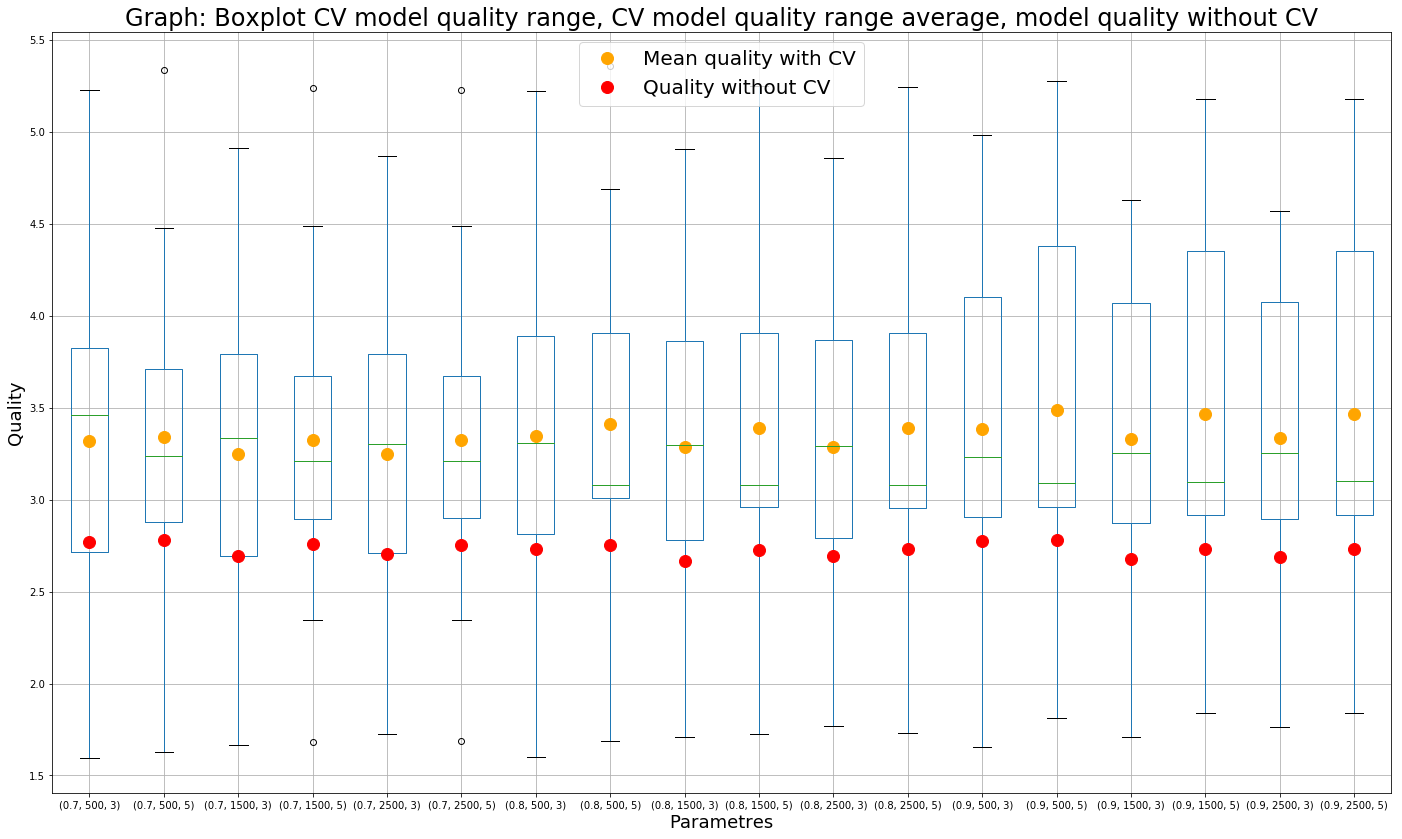

In [40]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Опять-таки существенных изменений в качестве не произошло. Давайте выделим некоторые закономерности.

1) В обоих случаях (с использованием кросс-валидации и без использования) качество при увеличении доли подвыборки незначительно падает

2) При глубине равной 5 качество несколько ниже когда у дерева глубина 3

3) При росте количества деревьев качество слегка увеличивается

Давайте тогда зафиксируем подвыборку на 0.7, глубину на 0.3, а количество деревьев будем увеличивать. Посмотрим сможем ли мы улучшить качество.

In [41]:
name_model = 'GBR_stoch'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_trees = [3000, 4000, 5000]
list_depth = [3]
list_subsamples = [0.7]


for subsample in list_subsamples:
    for tree in list_trees:
        for depth in list_depth:
            params = (subsample, tree, depth)
            model = ensemble.GradientBoostingRegressor(
                learning_rate = 0.01, max_depth = depth, n_estimators = tree, subsample = subsample, random_state = 1)
            model_fit = model.fit(x_train, y_train)
            dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
            dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [42]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: GBR_stoch


,"(0.7, 3000, 3)","(0.7, 4000, 3)","(0.7, 5000, 3)"
0,3.132,3.127,3.126
1,2.161,2.177,2.185
2,3.851,3.848,3.846
3,3.470,3.468,3.467
4,4.849,4.839,4.831
5,2.924,2.944,2.952
6,2.649,2.658,2.662
7,4.114,4.113,4.113
8,1.743,1.754,1.759
9,3.600,3.601,3.603


In [43]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: GBR_stoch


,"(0.7, 3000, 3)","(0.7, 4000, 3)","(0.7, 5000, 3)"
0,2.716,2.728,2.737


Model quality assessment 
Model: GBR_stoch


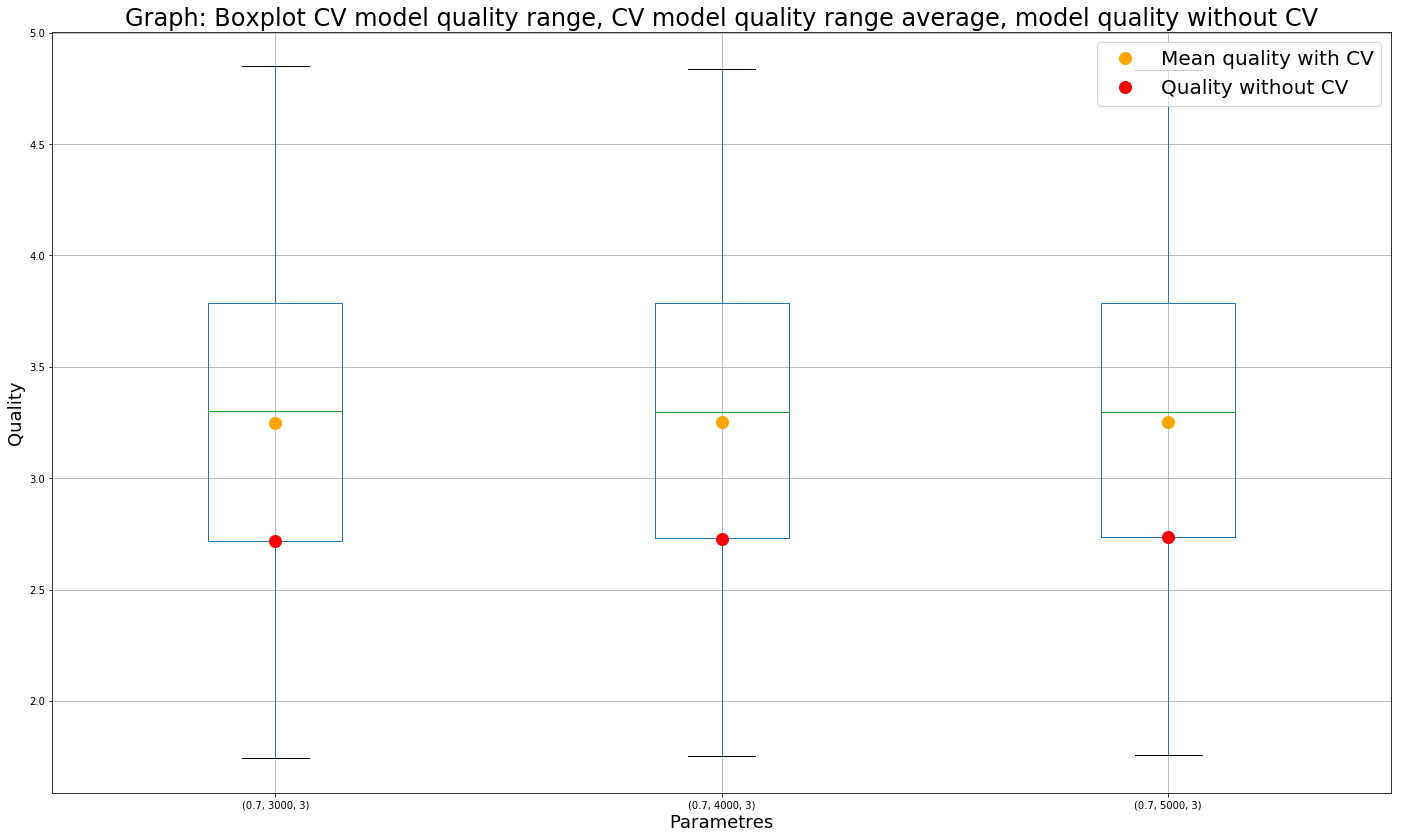

In [44]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

После определенного порога количества деревьев их дальнейший рост приводит к переобучению модели. 
Фиксируем результаты и двигаемся к следующей моделе - Random Forest

In [45]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch
0,2.927,3.536,3.132
1,2.229,2.197,2.161
2,3.903,5.188,3.851
3,4.560,2.900,3.470
4,4.522,4.930,4.849
5,3.242,2.823,2.924
6,2.990,2.326,2.649
7,4.048,3.485,4.114
8,1.743,1.753,1.743
9,3.175,2.404,3.600


In [46]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch
0,0.884,1.088,0.882


In [47]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch
0,2.665,2.779,2.716


# Decision Trees: Random Forest

In [48]:
name_model = 'RF'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_features = ['auto']
list_trees = [50, 100, 500, 1500]
list_depth = [2, 3, 5, 7, 10]

for feature in list_features:
    for tree in list_trees:
        for depth in list_depth:
            params = (tree, depth)
            model = ensemble.RandomForestRegressor(
                max_depth = depth, n_estimators = tree, max_features = feature, random_state = 1)
            model_fit = model.fit(x_train, y_train)
            dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
            dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

C:\Users\Alexander\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
C:\Users\Alexander\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [49]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: RF


,"(50, 2)","(50, 3)","(50, 5)","(50, 7)","(50, 10)","(100, 2)","(100, 3)","(100, 5)","(100, 7)","(100, 10)","(500, 2)","(500, 3)","(500, 5)","(500, 7)","(500, 10)","(1500, 2)","(1500, 3)","(1500, 5)","(1500, 7)","(1500, 10)"
0,4.512,3.554,3.202,3.055,3.090,4.513,3.574,3.155,3.035,3.057,4.536,3.624,3.185,3.063,3.054,4.535,3.638,3.187,3.084,3.062
1,3.097,2.706,2.547,2.436,2.370,3.084,2.672,2.589,2.483,2.405,3.047,2.683,2.608,2.493,2.437,3.039,2.687,2.614,2.503,2.425
2,3.778,3.716,3.795,3.818,3.904,3.800,3.693,3.840,3.835,3.873,3.705,3.621,3.744,3.735,3.736,3.713,3.644,3.750,3.758,3.750
3,3.858,3.881,3.655,3.609,3.597,3.804,3.841,3.637,3.489,3.560,3.853,3.891,3.579,3.483,3.510,3.892,3.938,3.661,3.569,3.555
4,6.954,6.505,6.298,6.231,6.259,6.929,6.430,6.243,6.114,6.167,6.797,6.371,6.127,6.056,6.042,6.739,6.328,6.081,6.038,6.013
5,3.303,3.252,2.934,3.152,3.249,3.562,3.237,3.052,3.281,3.224,3.506,3.283,3.143,3.178,3.141,3.412,3.179,3.091,3.069,3.049
6,3.642,3.371,3.281,3.241,3.184,3.624,3.283,3.195,3.241,3.172,3.704,3.221,3.088,3.075,3.049,3.617,3.143,3.010,2.975,2.957
7,4.550,4.577,4.240,4.240,4.354,4.361,4.356,4.133,4.167,4.182,4.318,4.186,4.112,4.103,4.113,4.353,4.234,4.182,4.165,4.127
8,3.140,2.111,1.588,1.562,1.588,3.129,2.061,1.651,1.559,1.612,2.976,2.004,1.692,1.634,1.665,2.991,2.016,1.676,1.625,1.617
9,4.666,3.913,3.708,3.729,3.720,4.789,4.146,3.962,4.002,3.876,4.706,4.009,3.860,3.856,3.828,4.676,4.045,3.851,3.853,3.849


In [50]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: RF


,"(50, 2)","(50, 3)","(50, 5)","(50, 7)","(50, 10)","(100, 2)","(100, 3)","(100, 5)","(100, 7)","(100, 10)","(500, 2)","(500, 3)","(500, 5)","(500, 7)","(500, 10)","(1500, 2)","(1500, 3)","(1500, 5)","(1500, 7)","(1500, 10)"
0,4.559,3.783,3.19,3.089,3.043,4.43,3.689,3.085,2.948,2.896,4.535,3.801,3.106,2.952,2.894,4.572,3.819,3.122,2.955,2.895


Model quality assessment 
Model: RF


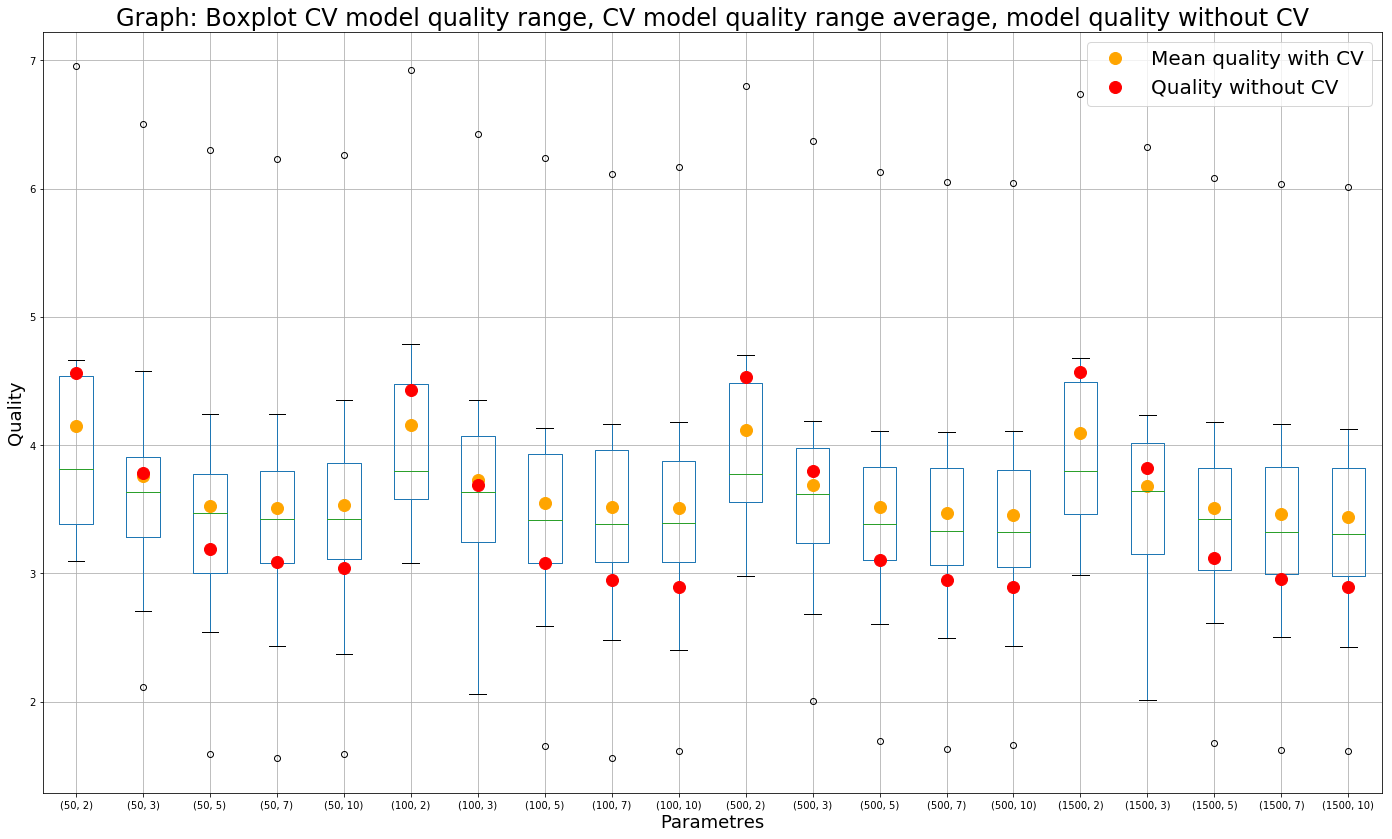

In [51]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Случайный лес при лучших параметрах показывает сопоставимое качество с градиентным бустингом. Однако заметно небольшое отставание по качеству.

Также мы наблюдаем, что с увеличением глубины качество растет достаточно заметно, и слабо выраженый рост при увеличении количества деревьев.

Давайте будем увеличивать этьи два параметра

In [52]:
name_model = 'RF'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_features = ['auto']
list_trees = [1500, 2000, 2500]
list_depth = [10, 15, 50]

for feature in list_features:
    for tree in list_trees:
        for depth in list_depth:
            params = (tree, depth)
            model = ensemble.RandomForestRegressor(
                max_depth = depth, n_estimators = tree, max_features = feature, random_state = 1)
            model_fit = model.fit(x_train, y_train)
            dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
            dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

C:\Users\Alexander\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [53]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: RF


,"(1500, 10)","(1500, 15)","(1500, 50)","(2000, 10)","(2000, 15)","(2000, 50)","(2500, 10)","(2500, 15)","(2500, 50)"
0,3.062,3.063,3.065,3.070,3.073,3.075,3.064,3.068,3.068
1,2.425,2.438,2.435,2.422,2.430,2.425,2.419,2.426,2.423
2,3.750,3.731,3.731,3.752,3.732,3.731,3.751,3.733,3.734
3,3.555,3.544,3.541,3.543,3.530,3.526,3.534,3.530,3.529
4,6.013,6.020,6.027,6.020,6.030,6.035,6.007,6.022,6.028
5,3.049,3.062,3.067,3.053,3.062,3.062,3.065,3.072,3.071
6,2.957,2.948,2.949,2.970,2.960,2.963,2.973,2.965,2.965
7,4.127,4.138,4.137,4.130,4.108,4.108,4.122,4.106,4.104
8,1.617,1.651,1.651,1.620,1.648,1.648,1.619,1.641,1.641
9,3.849,3.839,3.835,3.822,3.823,3.821,3.887,3.885,3.883


In [54]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: RF


,"(1500, 10)","(1500, 15)","(1500, 50)","(2000, 10)","(2000, 15)","(2000, 50)","(2500, 10)","(2500, 15)","(2500, 50)"
0,2.895,2.876,2.88,2.901,2.884,2.888,2.901,2.887,2.893


Model quality assessment 
Model: RF


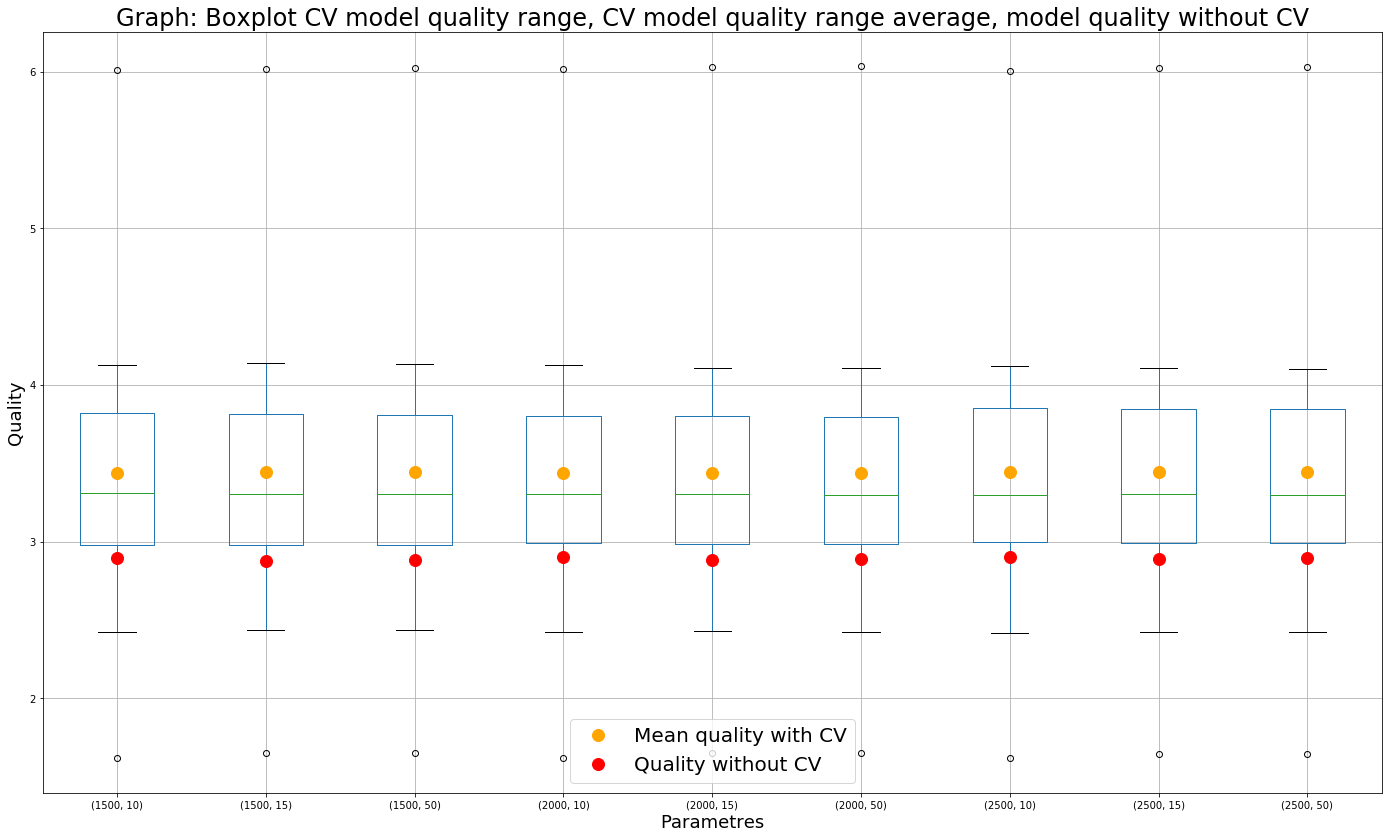

In [55]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Как мы наблюдаем существует порог глубины и деревьев, перешагнув который модель начинает переобучаться. 

Запишем результаты

In [56]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF
0,2.927,3.536,3.132,3.075
1,2.229,2.197,2.161,2.425
2,3.903,5.188,3.851,3.731
3,4.560,2.900,3.470,3.526
4,4.522,4.930,4.849,6.035
5,3.242,2.823,2.924,3.062
6,2.990,2.326,2.649,2.963
7,4.048,3.485,4.114,4.108
8,1.743,1.753,1.743,1.648
9,3.175,2.404,3.600,3.821


In [57]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch,RF
0,0.884,1.088,0.882,1.103


In [58]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF
0,2.665,2.779,2.716,2.876


# Decision Trees: Random Forest with bagging

In [59]:
name_model = 'RF_sqrt'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_features = ['sqrt']
list_trees = [100, 500, 1500]
list_depth = [5, 7, 10]

for feature in list_features:
    for tree in list_trees:
        for depth in list_depth:
            model = ensemble.RandomForestRegressor(
                max_depth = depth, n_estimators = tree, max_features = feature, random_state = 1)
            model_fit = model.fit(x_train, y_train)            
            params = (tree, depth)
            dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
            dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

C:\Users\Alexander\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [60]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: RF_sqrt


,"(100, 5)","(100, 7)","(100, 10)","(500, 5)","(500, 7)","(500, 10)","(1500, 5)","(1500, 7)","(1500, 10)"
0,3.595,3.597,3.930,3.816,3.706,3.814,3.853,3.675,3.714
1,3.524,3.241,3.220,3.494,3.225,3.147,3.450,3.166,3.047
2,5.561,5.169,5.327,5.472,5.290,5.435,5.284,5.227,5.260
3,3.729,3.294,3.295,3.684,3.426,3.360,3.636,3.401,3.344
4,6.611,6.005,6.314,6.368,6.380,6.378,6.361,6.425,6.385
5,2.966,2.752,2.999,2.921,2.846,2.904,2.868,2.795,2.897
6,2.583,2.550,2.576,2.441,2.332,2.195,2.414,2.333,2.288
7,3.293,3.056,3.340,3.565,3.324,3.383,3.559,3.369,3.366
8,1.703,1.932,1.615,1.922,1.912,1.750,1.887,1.841,1.792
9,2.636,2.274,2.393,2.595,2.502,2.512,2.544,2.514,2.519


In [61]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: RF_sqrt


,"(100, 5)","(100, 7)","(100, 10)","(500, 5)","(500, 7)","(500, 10)","(1500, 5)","(1500, 7)","(1500, 10)"
0,3.7,3.394,3.261,3.643,3.279,3.145,3.632,3.29,3.174


Model quality assessment 
Model: RF_sqrt


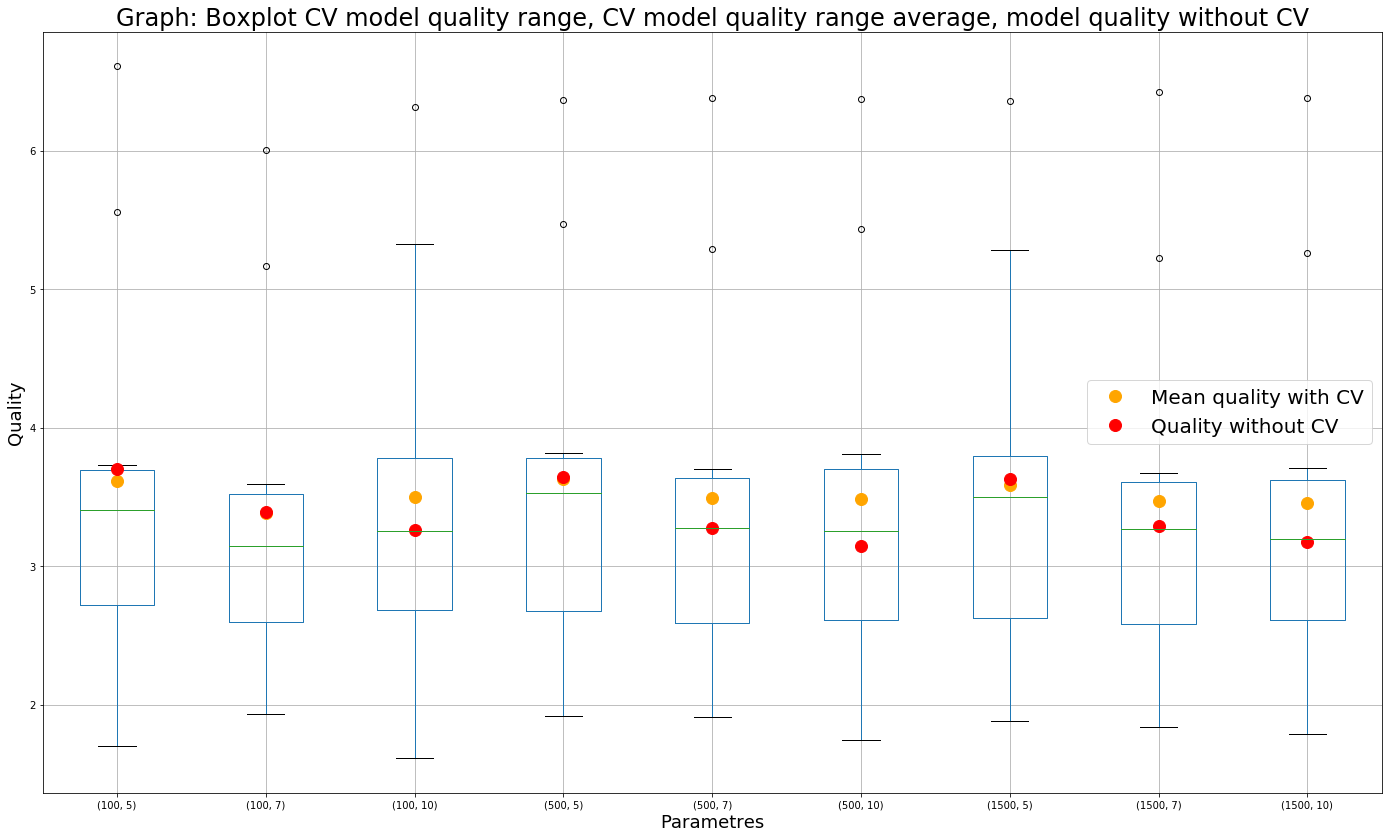

In [62]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Качество заметно ухудшилось, но с увеличением глубины каждого дерева и количества деревьев качество незначительно улучшается. Вряд ли нам удастся сильно улучшить показатели и достичь предыдущего максимума, но мы проведем дополнительное исследование. Увеличим глубину деревьев и их количество.

In [63]:
name_model = 'RF_sqrt'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_features = ['sqrt']
list_trees = [1500, 2500]
list_depth = [10, 25, 50]

for feature in list_features:
    for tree in list_trees:
        for depth in list_depth:
            model = ensemble.RandomForestRegressor(
                max_depth = depth, n_estimators = tree, max_features = feature, random_state = 1)
            model_fit = model.fit(x_train, y_train)            
            params = (tree, depth)
            dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
            dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

C:\Users\Alexander\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [64]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: RF_sqrt


,"(1500, 10)","(1500, 25)","(1500, 50)","(2500, 10)","(2500, 25)","(2500, 50)"
0,3.714,3.728,3.728,3.671,3.699,3.699
1,3.047,3.046,3.046,3.077,3.090,3.090
2,5.260,5.331,5.331,5.246,5.333,5.333
3,3.344,3.342,3.342,3.338,3.348,3.348
4,6.385,6.341,6.341,6.344,6.292,6.292
5,2.897,2.898,2.898,2.901,2.901,2.901
6,2.288,2.244,2.244,2.323,2.257,2.257
7,3.366,3.359,3.359,3.349,3.334,3.334
8,1.792,1.860,1.860,1.809,1.855,1.855
9,2.519,2.584,2.584,2.537,2.580,2.580


In [65]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: RF_sqrt


,"(1500, 10)","(1500, 25)","(1500, 50)","(2500, 10)","(2500, 25)","(2500, 50)"
0,3.174,3.166,3.166,3.183,3.166,3.166


Model quality assessment 
Model: RF_sqrt


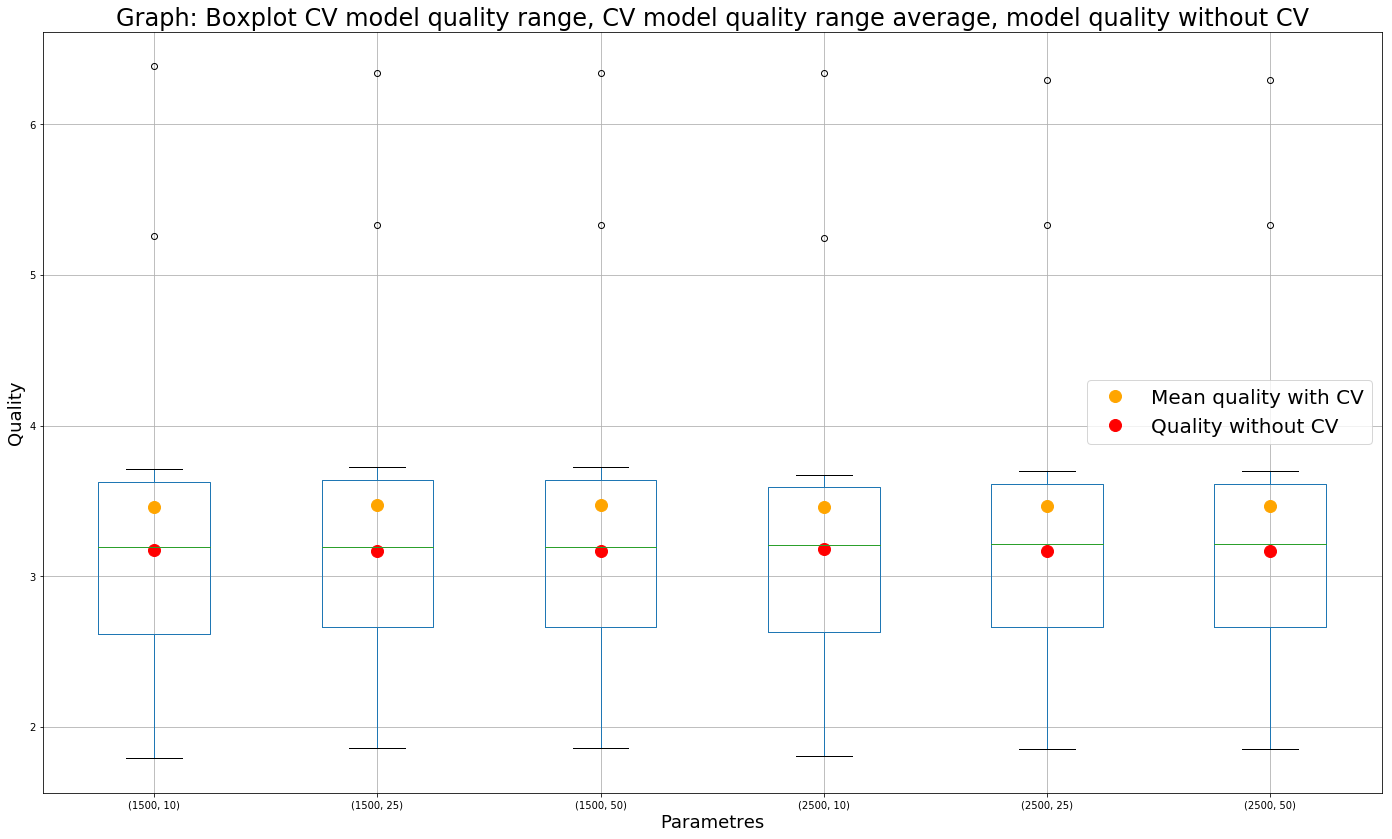

In [66]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Существенных улучшений в качестве модели при изменении параметров не случилось. 

Фиксируем результаты

In [67]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt
0,2.927,3.536,3.132,3.075,3.671
1,2.229,2.197,2.161,2.425,3.077
2,3.903,5.188,3.851,3.731,5.246
3,4.560,2.900,3.470,3.526,3.338
4,4.522,4.930,4.849,6.035,6.344
5,3.242,2.823,2.924,3.062,2.901
6,2.990,2.326,2.649,2.963,2.323
7,4.048,3.485,4.114,4.108,3.349
8,1.743,1.753,1.743,1.648,1.809
9,3.175,2.404,3.600,3.821,2.537


In [68]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt
0,0.884,1.088,0.882,1.103,1.3


In [69]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt
0,2.665,2.779,2.716,2.876,3.166


# Linear Model
## Analitical solution

In [70]:
# создадим вспомогательный вектор из единиц
vec_one = np.ones(x_train.shape[0])
vec_one = vec_one.reshape(x_train.shape[0], 1)
# преобразуем матрицу признаков и вектор ответов в нужный нам формат
X = np.hstack((vec_one, x_train))
X = np.matrix(X)
XT = X.T
XTX = XT*X
y = np.matrix(y_train)
XTy = XT*y
# убедимся что преобразования прошли успешно
print XTX.shape
print XTy.shape

(14L, 14L)
(14L, 1L)


In [71]:
# определим коэффициенты линейной регрессии
coef_analit = np.matrix(np.linalg.solve(XTX,XTy))
print coef_analit.shape
print coef_analit

(14L, 1L)
[[22.33983051]
 [-0.83884271]
 [ 1.42840065]
 [ 0.40532651]
 [ 0.67942473]
 [-2.53039124]
 [ 1.93381643]
 [ 0.10090715]
 [-3.23615418]
 [ 2.70318306]
 [-1.91729896]
 [-2.15578621]
 [ 0.58227649]
 [-4.13433172]]


In [72]:
# подготовим признаковое пространство тестовой выборки для прогнозирования
vec_one = np.ones(x_test.shape[0])
vec_one = vec_one.reshape(x_test.shape[0], 1)
X_test = np.hstack((vec_one, x_test))
X_test = np.matrix(X_test)
# сформируем вектор предсказаний на тестовой выборке
y_predict = X_test*coef_analit
# определим качество модели
mse = round((metrics.mean_squared_error(y_test, y_predict))**0.5,3)
print mse

4.453


Качество заметно ниже, чем при использовании решающих деревьев. Результаты занесем в таблицы на следующей функции. Там значения те же.

## Linear Regression
Полагаем, что результат не будет отличаться от аналитического решения

In [73]:
name_model = 'Analyt_Solve'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()



model = linear_model.LinearRegression()
model_fit = model.fit(x_train, y_train)
dataframe_cv['No params'] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
dataframe_noncv['No params'] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [74]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: Analyt_Solve


,No params
0,5.078
1,4.416
2,5.363
3,4.235
4,7.243
5,3.112
6,2.214
7,4.088
8,2.614
9,3.608


In [75]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: Analyt_Solve


,No params
0,4.453


Model quality assessment 
Model: Analyt_Solve


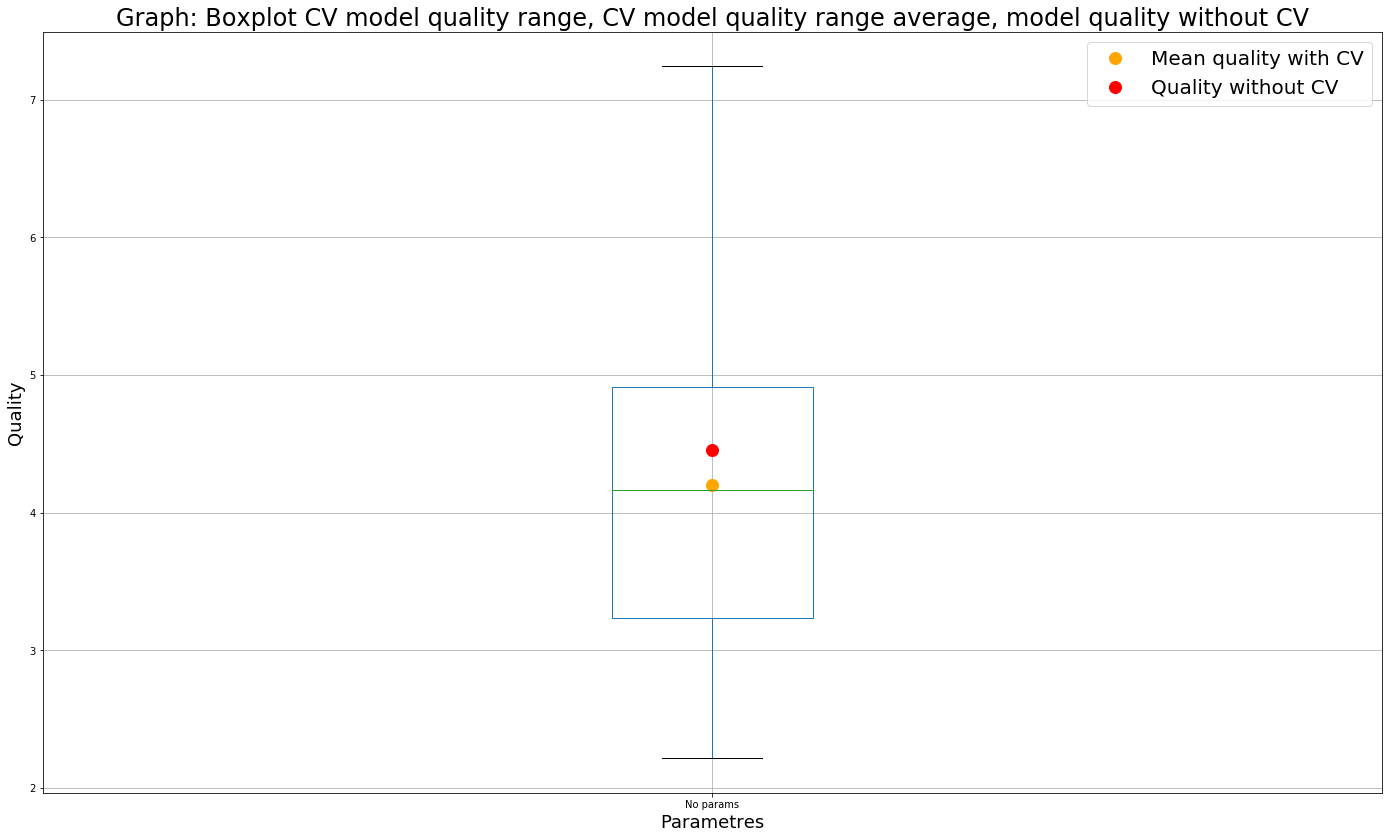

In [76]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

In [77]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve
0,2.927,3.536,3.132,3.075,3.671,5.078
1,2.229,2.197,2.161,2.425,3.077,4.416
2,3.903,5.188,3.851,3.731,5.246,5.363
3,4.560,2.900,3.470,3.526,3.338,4.235
4,4.522,4.930,4.849,6.035,6.344,7.243
5,3.242,2.823,2.924,3.062,2.901,3.112
6,2.990,2.326,2.649,2.963,2.323,2.214
7,4.048,3.485,4.114,4.108,3.349,4.088
8,1.743,1.753,1.743,1.648,1.809,2.614
9,3.175,2.404,3.600,3.821,2.537,3.608


In [78]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve
0,0.884,1.088,0.882,1.103,1.3,1.394


In [79]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve
0,2.665,2.779,2.716,2.876,3.166,4.453


## SGD Regressor
Давайте посмотрим на результаты, если использовать стохастический градиентный спуск с дополнительными параметрами:

- регуляризация L2
- регуляризация L1

In [80]:
model = linear_model.SGDRegressor(
    penalty = 'l2', alpha = 0.0001, max_iter = 1000000, random_state = 1, learning_rate = 'invscaling')

model_fit = model.fit(x_train, y_train)

mse_test_cv = model_selection.cross_val_score(model_fit, x_test, y_test, scoring = 'neg_mean_squared_error', cv = cv)
mse_test_cv = map(lambda x: round((-x)**0.5, 3), mse_test_cv)
mse_test_cv.append(round(np.mean(mse_test_cv), 3))
print mse_test_cv


y_predict = model_fit.predict(x_test)
mse_test_noncv = round((metrics.mean_squared_error(y_test, y_predict))**0.5,3)
print mse_test_noncv

C:\Users\Alexander\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[5.076, 4.415, 5.363, 4.234, 7.244, 3.112, 2.214, 4.087, 2.614, 3.609, 4.197]
4.454


Предварительный запуск стохастического градиентного спуска с ручными настройками показал крайне неудовлетворительные результаты в связи с тем, что требуется очень много спусков. Мы довели количество спусков до 1 млн. и результат все равно крайне не удовлетворительный. Вероятно это связано с тем, что признаковое пространство не отмасштабировано. Попробуем посмотреть каков будет результат при использовании настроек по умолчанию

In [81]:
model = linear_model.SGDRegressor()

model_fit = model.fit(x_train, y_train)

mse_test_cv = model_selection.cross_val_score(model_fit, x_test, y_test, scoring = 'neg_mean_squared_error', cv = cv)
mse_test_cv = map(lambda x: round((-x)**0.5, 3), mse_test_cv)
mse_test_cv.append(round(np.mean(mse_test_cv), 3))
print mse_test_cv


y_predict = model_fit.predict(x_test)
mse_test_noncv = round((metrics.mean_squared_error(y_test, y_predict))**0.5,3)
print mse_test_noncv


[5.385, 5.162, 7.688, 4.638, 11.551, 3.296, 3.858, 5.537, 4.538, 5.257, 5.691]
4.425


C:\Users\Alexander\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


По скорости работы - существенно быстрее. По качеству заметно ниже. Это связано с тем, что в настройках по умолчанию количество спусков равно 1 тыс. Не будем заносить результаты. Перейдем к следующей моделе.

## Ridge
Давайте посмотрим на результаты, если использовать линейную модель с регуляризацией L2

In [82]:
model = linear_model.Ridge()

model_fit = model.fit(x_train, y_train)

mse_test_cv = model_selection.cross_val_score(model_fit, x_test, y_test, scoring = 'neg_mean_squared_error', cv = cv)
mse_test_cv = map(lambda x: round((-x)**0.5, 3), mse_test_cv)
mse_test_cv.append(round(np.mean(mse_test_cv), 3))
print mse_test_cv


y_predict = model_fit.predict(x_test)
mse_test_noncv = round((metrics.mean_squared_error(y_test, y_predict))**0.5,3)
print mse_test_noncv

[5.022, 4.329, 5.38, 4.156, 7.281, 3.143, 2.2, 4.066, 2.588, 3.646, 4.181]
4.451


Качество незначительно лучше, чем при использовании Linear Regression. Давайте сравним значения коэффициентов.

In [83]:
coef_ridge = np.array(model_fit.coef_)
coef_ridge = coef_ridge.reshape(x_train.shape[1], 1)
coef_intercept = model_fit.intercept_.reshape(1,1)
coef_ridge = np.vstack((coef_intercept, coef_ridge))
print 'Коэффициенты RIDGE:', map(lambda x: round(x, 2), coef_ridge)

coef_analit = coef_analit.reshape(x_train.shape[1]+1,1)
print 'Коэффициенты LReg:', map(lambda x: round(x, 2), coef_analit)

Коэффициенты RIDGE: [22.34, -0.82, 1.39, 0.37, 0.69, -2.48, 1.95, 0.09, -3.18, 2.59, -1.81, -2.15, 0.58, -4.11]
Коэффициенты LReg: [22.34, -0.84, 1.43, 0.41, 0.68, -2.53, 1.93, 0.1, -3.24, 2.7, -1.92, -2.16, 0.58, -4.13]


Видно, что регуляризация занижает значения весов некоторых признаков, которые не являются информативными.

Мы использовали параметры по умолчанию. Давайте посмотрим, как будут меняться результаты при изменении параметров.

In [84]:
name_model = 'LinReg_L2_Ridge'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 5, 10]

for alpha in list_alphas:
    params = (alpha)
    model = linear_model.Ridge(alpha = alpha)
    model_fit = model.fit(x_train, y_train)
    dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
    dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [85]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: LinReg_L2_Ridge


,0.0001,0.001,0.01,0.1,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,5.0,10.0
0,5.078,5.078,5.077,5.072,5.022,5.016,5.011,5.006,5.001,4.997,4.992,4.987,4.983,4.978,4.974,4.864,4.751
1,4.416,4.416,4.415,4.407,4.329,4.320,4.312,4.305,4.297,4.289,4.281,4.274,4.266,4.259,4.252,4.074,3.898
2,5.363,5.363,5.363,5.364,5.380,5.381,5.383,5.385,5.386,5.388,5.389,5.391,5.392,5.394,5.395,5.437,5.497
3,4.235,4.235,4.234,4.226,4.156,4.149,4.142,4.136,4.129,4.123,4.117,4.111,4.105,4.099,4.093,3.964,3.862
4,7.243,7.243,7.243,7.247,7.281,7.284,7.288,7.291,7.295,7.298,7.302,7.305,7.308,7.312,7.315,7.401,7.508
5,3.112,3.112,3.112,3.115,3.143,3.146,3.149,3.152,3.155,3.158,3.160,3.163,3.166,3.169,3.172,3.248,3.352
6,2.214,2.214,2.214,2.212,2.200,2.199,2.198,2.198,2.197,2.196,2.195,2.195,2.194,2.194,2.193,2.196,2.232
7,4.088,4.088,4.087,4.085,4.066,4.064,4.063,4.061,4.059,4.057,4.056,4.054,4.052,4.051,4.049,4.014,3.995
8,2.614,2.614,2.614,2.611,2.588,2.586,2.584,2.582,2.579,2.577,2.575,2.573,2.571,2.569,2.567,2.521,2.474
9,3.608,3.608,3.608,3.612,3.646,3.649,3.652,3.655,3.658,3.661,3.664,3.667,3.670,3.672,3.675,3.720,3.711


In [86]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: LinReg_L2_Ridge


,0.0001,0.001,0.01,0.1,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,5.0,10.0
0,4.453,4.453,4.453,4.453,4.451,4.451,4.45,4.45,4.45,4.45,4.45,4.45,4.45,4.449,4.449,4.449,4.457


Model quality assessment 
Model: LinReg_L2_Ridge


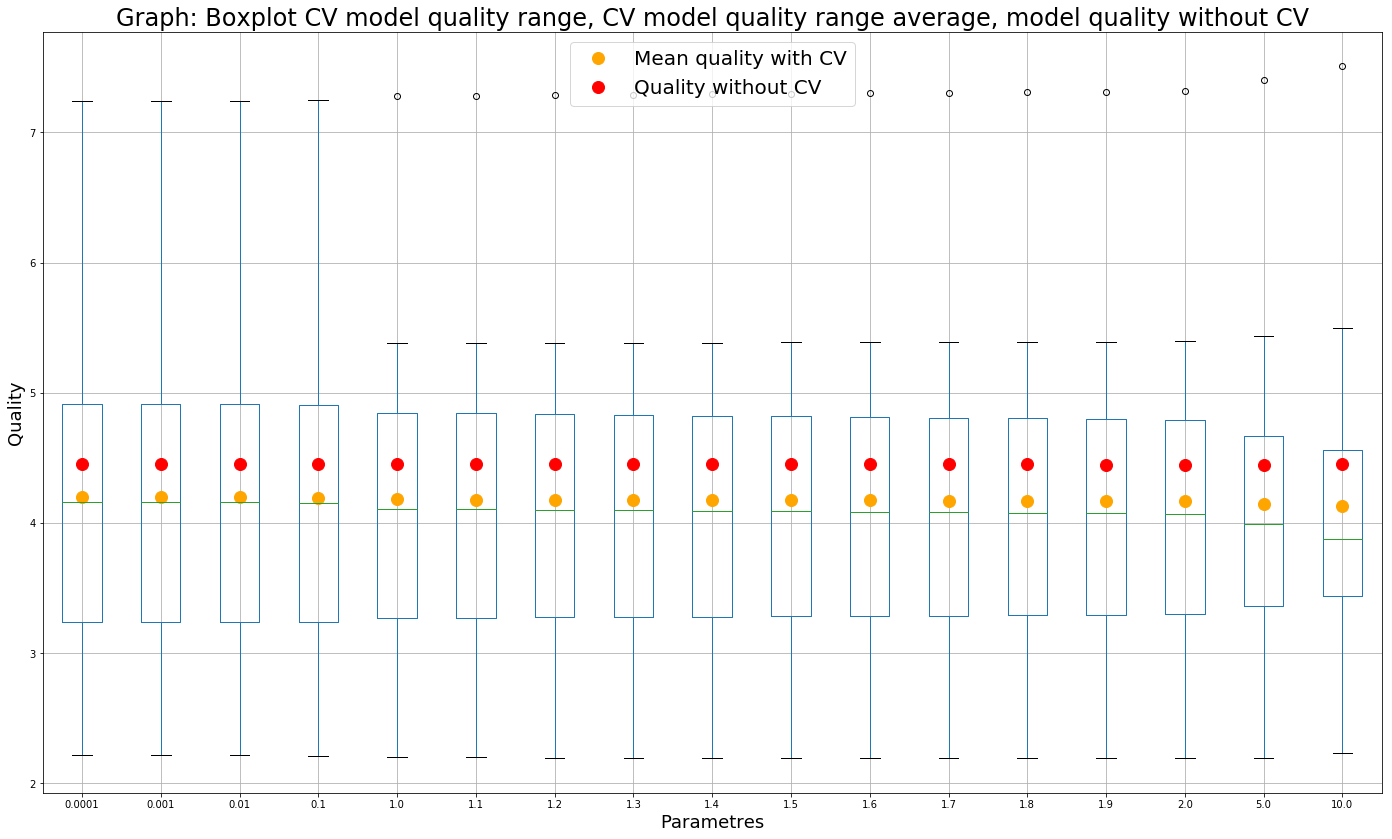

In [87]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Видно, что существует некоторый порог значения коэффициента перед регуляризацией, до которого качество модели улучшается, а после - ухудшается.

Однако, в целом результаты полученные с использованием L2 регуляризации немного лучше результатов полученных без нее.

Зафиксируем

In [88]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge
0,2.927,3.536,3.132,3.075,3.671,5.078,4.751
1,2.229,2.197,2.161,2.425,3.077,4.416,3.898
2,3.903,5.188,3.851,3.731,5.246,5.363,5.497
3,4.560,2.900,3.470,3.526,3.338,4.235,3.862
4,4.522,4.930,4.849,6.035,6.344,7.243,7.508
5,3.242,2.823,2.924,3.062,2.901,3.112,3.352
6,2.990,2.326,2.649,2.963,2.323,2.214,2.232
7,4.048,3.485,4.114,4.108,3.349,4.088,3.995
8,1.743,1.753,1.743,1.648,1.809,2.614,2.474
9,3.175,2.404,3.600,3.821,2.537,3.608,3.711


In [89]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge
0,0.884,1.088,0.882,1.103,1.3,1.394,1.447


In [90]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge
0,2.665,2.779,2.716,2.876,3.166,4.453,4.449


## Lasso
Давайте посмотрим на результаты, если использовать линейную модель с регуляризацией L1

In [91]:
name_model = 'LinReg_L1_Lasso'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 5, 10]

for alpha in list_alphas:
    params = (alpha)
    model = linear_model.Lasso(alpha = alpha)
    model_fit = model.fit(x_train, y_train)
    dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
    dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [92]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: LinReg_L1_Lasso


,0.0001,0.001,0.01,0.1,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,5.0,10.0
0,5.078,5.074,5.045,4.788,4.074,4.032,3.990,3.950,3.910,3.872,3.834,3.796,3.760,3.725,3.691,3.637,4.366
1,4.415,4.411,4.366,3.976,4.183,4.274,4.370,4.469,4.572,4.679,4.789,4.902,5.017,5.137,5.253,8.403,10.875
2,5.363,5.365,5.390,5.617,6.794,6.881,6.972,7.065,7.162,7.261,7.362,7.466,7.573,7.682,7.793,10.615,12.625
3,4.235,4.230,4.189,3.828,3.854,3.931,4.009,4.090,4.171,4.255,4.340,4.426,4.513,4.602,4.692,7.673,9.792
4,7.243,7.247,7.290,7.844,8.276,8.247,8.222,8.199,8.178,8.161,8.146,8.134,8.125,8.118,8.114,9.034,10.890
5,3.112,3.115,3.143,3.486,4.277,4.319,4.365,4.417,4.472,4.532,4.595,4.663,4.734,4.808,4.886,7.382,9.530
6,2.214,2.213,2.206,2.256,3.338,3.503,3.682,3.871,4.070,4.277,4.447,4.611,4.692,4.774,4.858,7.530,9.580
7,4.088,4.087,4.080,4.057,4.871,5.024,5.181,5.341,5.504,5.671,5.840,6.011,6.184,6.360,6.534,9.734,12.027
8,2.614,2.613,2.606,2.573,2.123,2.122,2.125,2.130,2.138,2.149,2.163,2.180,2.199,2.221,2.245,3.864,5.862
9,3.609,3.616,3.699,4.784,4.297,4.304,4.315,4.330,4.350,4.374,4.402,4.434,4.470,4.511,4.554,6.216,7.595


In [93]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: LinReg_L1_Lasso


,0.0001,0.001,0.01,0.1,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,5.0,10.0
0,4.453,4.453,4.452,4.562,5.467,5.524,5.583,5.645,5.708,5.774,5.842,5.911,5.983,6.056,6.131,8.507,9.595


Model quality assessment 
Model: LinReg_L1_Lasso


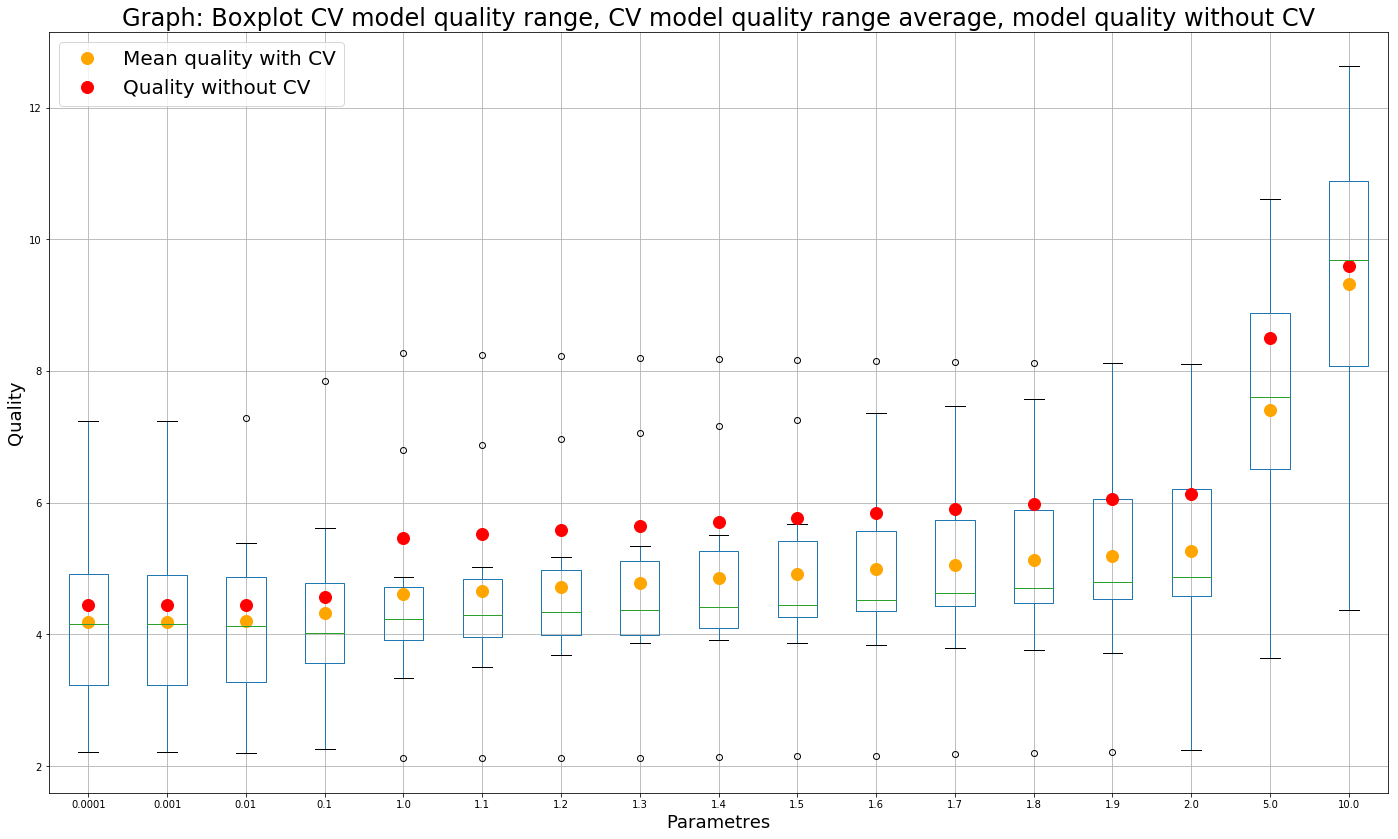

In [94]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Lasso показывает на данном датасете результаты значительно ниже Ridge и более того, с увеличением коэффициента перед регуляризатором Lasso качество стабильно снижается.

Давайте посмотрим на весовые коэффициенты регрессии при последнем коэффициенте регуляризатора

In [95]:
print round(model_fit.intercept_,3)
print map(lambda x: round(x, 3), model_fit.coef_)

22.34
[-0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0]


Мы наблюдаем обнуление большинства коэффициентов. Наибольший вес имеет последний коэффициент, перед признаком LSTAT (процент населения с низким статусом). Этот признак имеет ярко выраженную линейную зависимость. В этом и есть причина. Другими словами, наши линейные модели могут использовать только этот признак и будут выдавать сопоставимое качество.

Фиксируем результаты.

In [96]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso
0,2.927,3.536,3.132,3.075,3.671,5.078,4.751,5.078
1,2.229,2.197,2.161,2.425,3.077,4.416,3.898,4.415
2,3.903,5.188,3.851,3.731,5.246,5.363,5.497,5.363
3,4.560,2.900,3.470,3.526,3.338,4.235,3.862,4.235
4,4.522,4.930,4.849,6.035,6.344,7.243,7.508,7.243
5,3.242,2.823,2.924,3.062,2.901,3.112,3.352,3.112
6,2.990,2.326,2.649,2.963,2.323,2.214,2.232,2.214
7,4.048,3.485,4.114,4.108,3.349,4.088,3.995,4.088
8,1.743,1.753,1.743,1.648,1.809,2.614,2.474,2.614
9,3.175,2.404,3.600,3.821,2.537,3.608,3.711,3.609


In [97]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso
0,0.884,1.088,0.882,1.103,1.3,1.394,1.447,1.394


In [98]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso
0,2.665,2.779,2.716,2.876,3.166,4.453,4.449,4.452


## ElasticNet
Давайте посмотрим на результаты, если использовать линейную модель с регуляризацией L1 и L2 одновременно

In [100]:
name_model = 'LinReg_ElasticNet'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_alphas = [0.0001, 0.1, 1, 1.5, 2.0]
list_l1_ratio = [0.0001, 0.01, 1]

for alpha in list_alphas:
    for ratio in list_l1_ratio:
        params = (alpha, ratio)
        model = linear_model.ElasticNet(alpha = alpha, l1_ratio = ratio)
        model_fit = model.fit(x_train, y_train)
        dataframe_cv[params] = make_df_cv(model_fit, x_test, y_test, cv, decimal)
        dataframe_noncv[params] = make_df_noncv(model_fit, x_test, y_test, decimal)

In [101]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: LinReg_ElasticNet


,"(0.0001, 0.0001)","(0.0001, 0.01)","(0.0001, 1)","(0.1, 0.0001)","(0.1, 0.01)","(0.1, 1)","(1, 0.0001)","(1, 0.01)","(1, 1)","(1.5, 0.0001)","(1.5, 0.01)","(1.5, 1)","(2.0, 0.0001)","(2.0, 0.01)","(2.0, 1)"
0,5.077,5.077,5.078,4.700,4.700,4.788,4.596,4.590,4.074,4.589,4.583,3.872,4.567,4.560,3.691
1,4.415,4.415,4.415,3.834,3.834,3.976,5.434,5.425,4.183,6.129,6.122,4.679,6.640,6.635,5.253
2,5.363,5.363,5.363,5.539,5.540,5.617,6.918,6.916,6.794,7.496,7.499,7.261,7.957,7.962,7.793
3,4.234,4.234,4.235,3.835,3.834,3.828,5.084,5.077,3.854,5.615,5.609,4.255,6.018,6.013,4.692
4,7.243,7.243,7.243,7.569,7.570,7.844,8.322,8.324,8.276,8.553,8.554,8.161,8.737,8.739,8.114
5,3.112,3.112,3.112,3.416,3.417,3.486,4.707,4.704,4.277,5.207,5.204,4.532,5.602,5.601,4.886
6,2.214,2.214,2.214,2.270,2.269,2.256,3.797,3.793,3.338,4.397,4.394,4.277,4.864,4.864,4.858
7,4.087,4.087,4.088,3.999,4.000,4.057,5.619,5.615,4.871,6.366,6.365,5.671,6.946,6.947,6.534
8,2.613,2.613,2.614,2.453,2.454,2.573,2.708,2.703,2.123,2.910,2.904,2.149,3.087,3.082,2.245
9,3.609,3.609,3.609,3.673,3.680,4.784,3.247,3.252,4.297,3.519,3.524,4.374,3.801,3.806,4.554


In [102]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: LinReg_ElasticNet


,"(0.0001, 0.0001)","(0.0001, 0.01)","(0.0001, 1)","(0.1, 0.0001)","(0.1, 0.01)","(0.1, 1)","(1, 0.0001)","(1, 0.01)","(1, 1)","(1.5, 0.0001)","(1.5, 0.01)","(1.5, 1)","(2.0, 0.0001)","(2.0, 0.01)","(2.0, 1)"
0,4.453,4.453,4.453,4.553,4.552,4.562,5.747,5.745,5.467,6.154,6.153,5.774,6.461,6.462,6.131


Model quality assessment 
Model: LinReg_ElasticNet


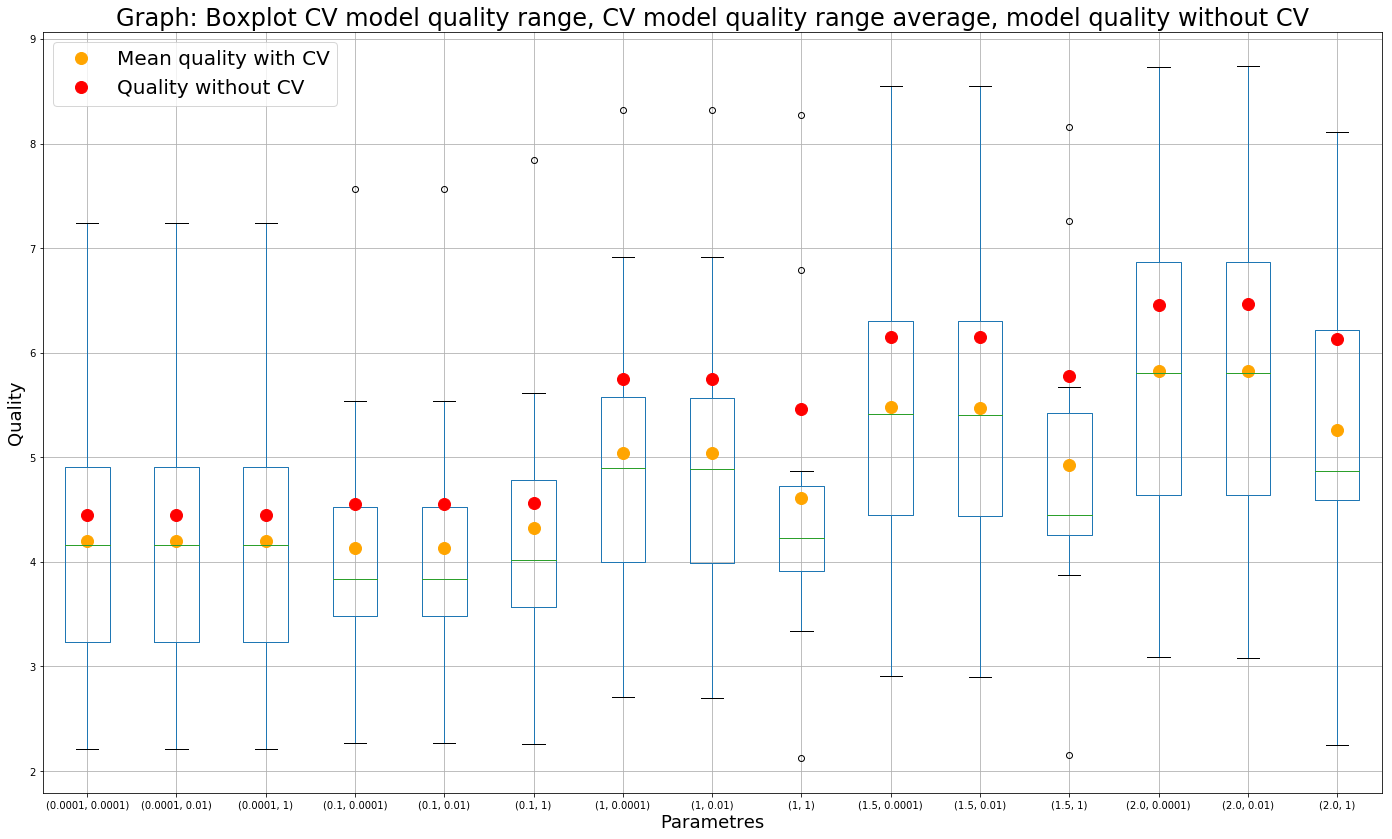

In [103]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

В целом, мы видим, что результаты хуже чем при использовании регуляризации L2 и лучше, чем при использовании L1.

Запишем.

In [104]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet
0,2.927,3.536,3.132,3.075,3.671,5.078,4.751,5.078,4.700
1,2.229,2.197,2.161,2.425,3.077,4.416,3.898,4.415,3.834
2,3.903,5.188,3.851,3.731,5.246,5.363,5.497,5.363,5.539
3,4.560,2.900,3.470,3.526,3.338,4.235,3.862,4.235,3.835
4,4.522,4.930,4.849,6.035,6.344,7.243,7.508,7.243,7.569
5,3.242,2.823,2.924,3.062,2.901,3.112,3.352,3.112,3.416
6,2.990,2.326,2.649,2.963,2.323,2.214,2.232,2.214,2.270
7,4.048,3.485,4.114,4.108,3.349,4.088,3.995,4.088,3.999
8,1.743,1.753,1.743,1.648,1.809,2.614,2.474,2.614,2.453
9,3.175,2.404,3.600,3.821,2.537,3.608,3.711,3.609,3.673


In [105]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet
0,0.884,1.088,0.882,1.103,1.3,1.394,1.447,1.394,1.46


In [106]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet
0,2.665,2.779,2.716,2.876,3.166,4.453,4.449,4.452,4.453


# Линейные модели на полиномиальных признаках
Давайте преобразуем признаковое пространство, добавив туда полиномов и посмотрим как изменится качество

Изначальное предположение - качество может улучшиться

Будем проверять качество следующих моделей:

- Ridge
- Lasso

## Ridge polynomial features

In [107]:
name_model = 'LinReg_L2_Poly'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_poly = [2, 3, 4]
list_alphas = [0.001, 0.01, 0.1, 1, 1.5, 2.0, 5, 10]


for poly in list_poly:
    for alpha in list_alphas:
        poly_model = preprocessing.PolynomialFeatures(poly)
        poly_x_train = poly_model.fit_transform(x_train) 
        poly_x_test = poly_model.fit_transform(x_test)
        params = (poly, alpha)
        model = linear_model.Ridge(alpha = alpha)
        model_fit = model.fit(poly_x_train, y_train)
        dataframe_cv[params] = make_df_cv(model_fit, poly_x_test, y_test, cv, decimal)
        dataframe_noncv[params] = make_df_noncv(model_fit, poly_x_test, y_test, decimal)

In [108]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: LinReg_L2_Poly


,"(2, 0.001)","(2, 0.01)","(2, 0.1)","(2, 1)","(2, 1.5)","(2, 2.0)","(2, 5)","(2, 10)","(3, 0.001)","(3, 0.01)",...,"(3, 5)","(3, 10)","(4, 0.001)","(4, 0.01)","(4, 0.1)","(4, 1)","(4, 1.5)","(4, 2.0)","(4, 5)","(4, 10)"
0,5.369,5.325,4.678,3.949,3.898,3.872,3.826,3.831,5.620,5.330,...,3.848,3.792,4.121,4.113,4.062,3.960,3.949,3.947,3.983,4.040
1,5.207,4.519,3.608,2.720,2.611,2.586,2.690,2.781,8.701,8.489,...,3.421,3.270,9.353,9.310,9.010,8.168,7.975,7.846,7.524,7.324
2,8.033,7.751,6.895,5.522,5.307,5.171,4.847,4.722,16.401,15.955,...,10.335,8.967,13.451,13.405,13.159,13.307,13.418,13.489,13.548,13.306
3,11.769,7.418,4.269,4.036,4.053,4.067,4.142,4.244,11.554,11.383,...,3.618,3.394,7.715,7.661,7.257,6.113,5.861,5.668,4.983,4.498
4,9.473,7.091,5.334,5.296,5.207,5.140,4.988,5.000,8.880,7.969,...,5.059,4.659,6.938,6.909,6.737,6.425,6.337,6.278,6.166,6.154
5,5.183,4.640,3.904,3.094,3.003,2.956,2.897,2.916,10.950,11.156,...,4.619,4.045,9.582,9.547,9.290,8.427,8.173,7.967,7.160,6.430
6,6.187,5.479,5.724,5.350,4.886,4.508,3.253,2.554,14.625,14.433,...,6.749,5.803,8.931,8.946,9.110,10.360,10.777,11.074,11.711,11.572
7,6.686,6.391,5.492,4.686,4.442,4.265,3.775,3.574,11.079,10.358,...,4.460,4.025,8.081,8.066,7.936,7.231,6.976,6.763,5.900,5.136
8,4.737,3.473,2.587,1.848,1.790,1.760,1.736,1.809,8.464,7.937,...,2.658,2.499,4.767,4.730,4.457,3.857,3.770,3.714,3.572,3.517
9,28.827,26.390,17.824,4.913,3.857,3.412,2.950,3.055,210.121,199.636,...,24.789,15.934,248.974,248.044,239.458,180.951,158.818,140.814,75.665,27.457


In [109]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: LinReg_L2_Poly


,"(2, 0.001)","(2, 0.01)","(2, 0.1)","(2, 1)","(2, 1.5)","(2, 2.0)","(2, 5)","(2, 10)","(3, 0.001)","(3, 0.01)",...,"(3, 5)","(3, 10)","(4, 0.001)","(4, 0.01)","(4, 0.1)","(4, 1)","(4, 1.5)","(4, 2.0)","(4, 5)","(4, 10)"
0,4.241,4.248,4.235,3.943,3.829,3.739,3.426,3.201,26.587,21.364,...,4.411,4.003,10.963,10.023,9.09,6.519,6.125,5.819,4.991,4.701


Model quality assessment 
Model: LinReg_L2_Poly


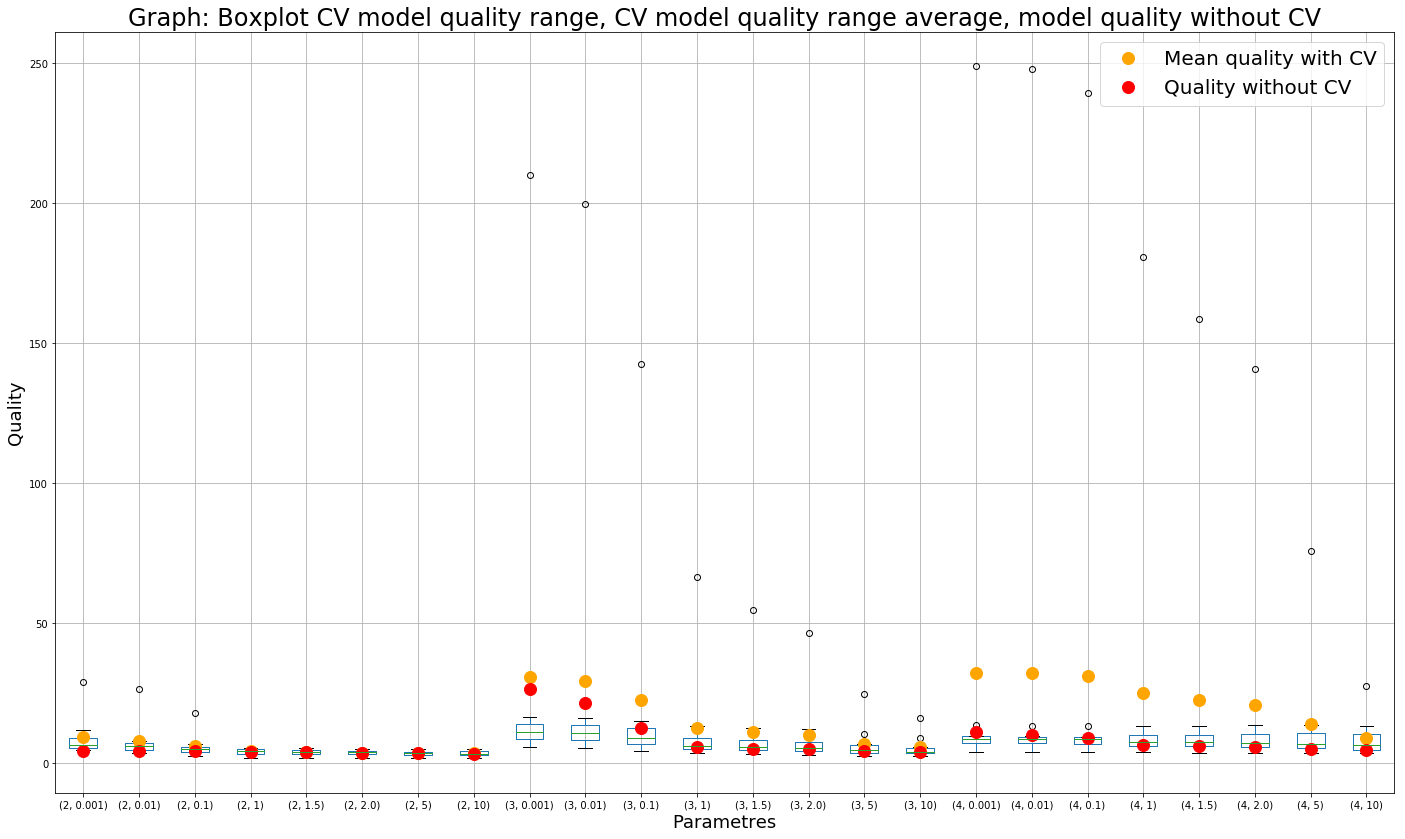

In [110]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Добавление полинома 2-й степени действительно улучшило результаты качества модели. Однако дальнейшее увеличение полинома приводит к существенному снижению качества. Давайте откорректируем поиск лучшей модели: зафиксируем степень полинома равной 2, и будем менять только коэффициент alpha.

In [111]:
name_model = 'LinReg_L2_Poly'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_poly = [2]
list_alphas = [0.001, 0.01, 0.1, 1, 1.5, 2.0, 5, 10]


for poly in list_poly:
    for alpha in list_alphas:
        poly_model = preprocessing.PolynomialFeatures(poly)
        poly_x_train = poly_model.fit_transform(x_train) 
        poly_x_test = poly_model.fit_transform(x_test)
        params = (poly, alpha)
        model = linear_model.Ridge(alpha = alpha)
        model_fit = model.fit(poly_x_train, y_train)
        dataframe_cv[params] = make_df_cv(model_fit, poly_x_test, y_test, cv, decimal)
        dataframe_noncv[params] = make_df_noncv(model_fit, poly_x_test, y_test, decimal)

In [112]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: LinReg_L2_Poly


,"(2, 0.001)","(2, 0.01)","(2, 0.1)","(2, 1)","(2, 1.5)","(2, 2.0)","(2, 5)","(2, 10)"
0,5.369,5.325,4.678,3.949,3.898,3.872,3.826,3.831
1,5.207,4.519,3.608,2.720,2.611,2.586,2.690,2.781
2,8.033,7.751,6.895,5.522,5.307,5.171,4.847,4.722
3,11.769,7.418,4.269,4.036,4.053,4.067,4.142,4.244
4,9.473,7.091,5.334,5.296,5.207,5.140,4.988,5.000
5,5.183,4.640,3.904,3.094,3.003,2.956,2.897,2.916
6,6.187,5.479,5.724,5.350,4.886,4.508,3.253,2.554
7,6.686,6.391,5.492,4.686,4.442,4.265,3.775,3.574
8,4.737,3.473,2.587,1.848,1.790,1.760,1.736,1.809
9,28.827,26.390,17.824,4.913,3.857,3.412,2.950,3.055


In [113]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: LinReg_L2_Poly


,"(2, 0.001)","(2, 0.01)","(2, 0.1)","(2, 1)","(2, 1.5)","(2, 2.0)","(2, 5)","(2, 10)"
0,4.241,4.248,4.235,3.943,3.829,3.739,3.426,3.201


Model quality assessment 
Model: LinReg_L2_Poly


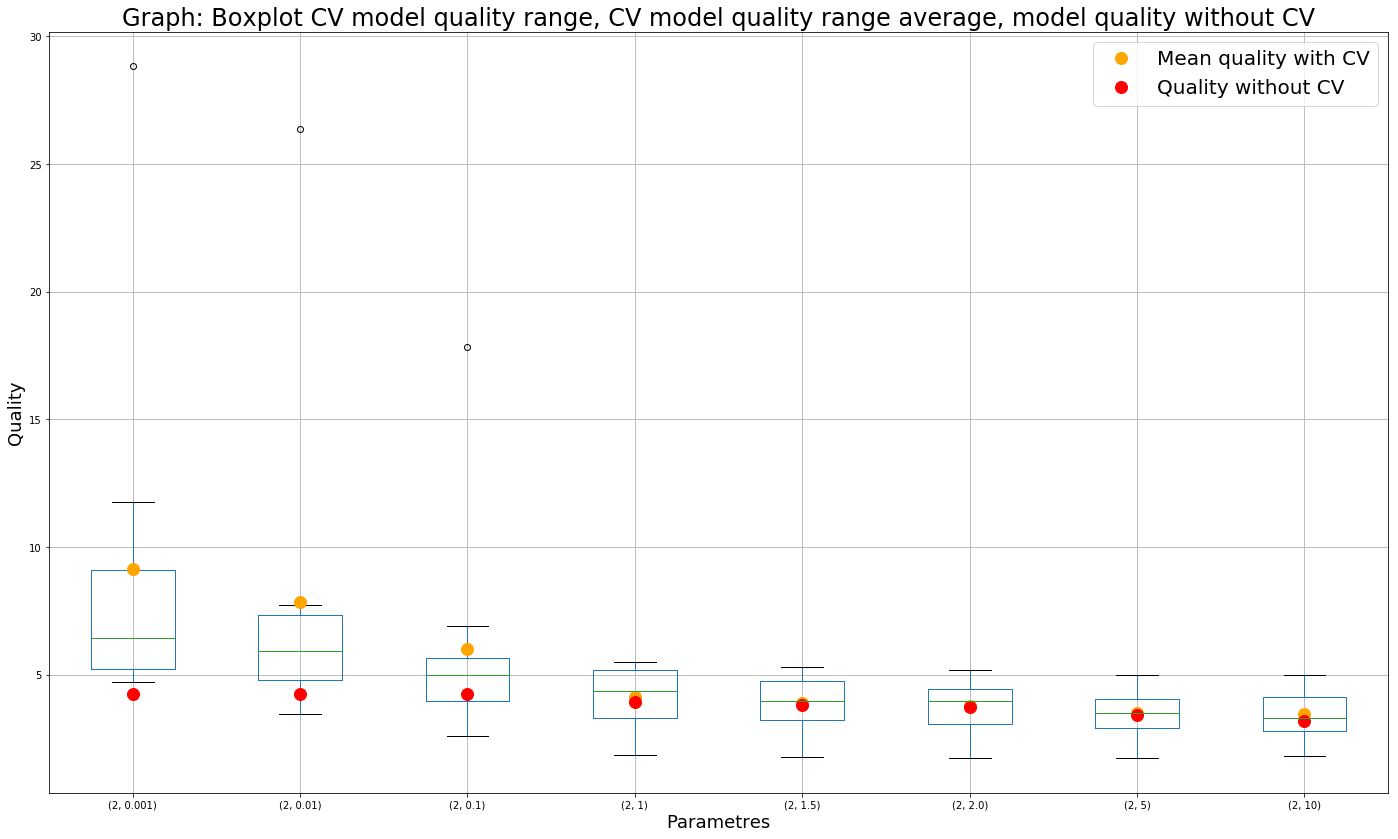

In [114]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

При увеличении коэффициента регуляризации мы наблюдаем до определенного порога увеличение качества модели и также снижение дисперсии. Наилучшие показатели лежат между значениями alpha равными 5 и 20.

Фиксируем результаты

In [115]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet,LinReg_L2_Poly
0,2.927,3.536,3.132,3.075,3.671,5.078,4.751,5.078,4.700,3.831
1,2.229,2.197,2.161,2.425,3.077,4.416,3.898,4.415,3.834,2.781
2,3.903,5.188,3.851,3.731,5.246,5.363,5.497,5.363,5.539,4.722
3,4.560,2.900,3.470,3.526,3.338,4.235,3.862,4.235,3.835,4.244
4,4.522,4.930,4.849,6.035,6.344,7.243,7.508,7.243,7.569,5.000
5,3.242,2.823,2.924,3.062,2.901,3.112,3.352,3.112,3.416,2.916
6,2.990,2.326,2.649,2.963,2.323,2.214,2.232,2.214,2.270,2.554
7,4.048,3.485,4.114,4.108,3.349,4.088,3.995,4.088,3.999,3.574
8,1.743,1.753,1.743,1.648,1.809,2.614,2.474,2.614,2.453,1.809
9,3.175,2.404,3.600,3.821,2.537,3.608,3.711,3.609,3.673,3.055


In [116]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet,LinReg_L2_Poly
0,0.884,1.088,0.882,1.103,1.3,1.394,1.447,1.394,1.46,0.959


In [117]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet,LinReg_L2_Poly
0,2.665,2.779,2.716,2.876,3.166,4.453,4.449,4.452,4.453,3.201


## Lasso polynomial features

In [118]:
name_model = 'LinReg_L1_Poly'
dataframe_cv = pd.DataFrame()
dataframe_noncv = pd.DataFrame()

list_poly = [2, 3]
list_alphas = [0.001, 0.01, 0.1, 1, 1.5, 2.0, 5, 10]


for poly in list_poly:
    for alpha in list_alphas:
        poly_model = preprocessing.PolynomialFeatures(poly)
        poly_x_train = poly_model.fit_transform(x_train) 
        poly_x_test = poly_model.fit_transform(x_test)
        params = (poly, alpha)
        model = linear_model.Lasso(alpha = alpha)
        model_fit = model.fit(poly_x_train, y_train)
        dataframe_cv[params] = make_df_cv(model_fit, poly_x_test, y_test, cv, decimal)
        dataframe_noncv[params] = make_df_noncv(model_fit, poly_x_test, y_test, decimal)

C:\Users\Alexander\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [119]:
print_dataframe_cv(name_model, dataframe_cv, cv)

Model quality assessment on CV (10 folds) 
Model: LinReg_L1_Poly


,"(2, 0.001)","(2, 0.01)","(2, 0.1)","(2, 1)","(2, 1.5)","(2, 2.0)","(2, 5)","(2, 10)","(3, 0.001)","(3, 0.01)","(3, 0.1)","(3, 1)","(3, 1.5)","(3, 2.0)","(3, 5)","(3, 10)"
0,4.875,4.671,3.875,3.152,2.965,2.903,3.577,4.269,5.522,3.984,3.643,3.352,3.574,3.670,4.193,4.217
1,3.953,3.123,2.816,3.243,3.558,3.869,7.214,10.477,8.780,6.358,3.348,4.110,4.637,4.728,5.796,6.640
2,6.569,4.675,4.180,5.267,6.094,6.859,10.404,12.201,17.549,11.700,5.110,4.837,5.875,6.494,8.461,9.472
3,4.571,3.819,3.799,3.352,3.859,4.314,7.489,9.297,8.608,5.448,3.156,4.833,4.330,4.412,6.177,7.167
4,7.109,4.844,6.019,7.302,7.275,7.318,9.179,10.546,5.664,4.617,4.775,6.838,7.745,8.276,8.796,8.876
5,4.265,2.824,3.099,3.225,3.320,3.543,5.919,9.066,10.296,4.425,3.579,5.093,5.415,5.433,5.622,5.806
6,5.731,5.126,2.286,2.102,2.538,2.999,6.202,9.039,10.498,6.205,2.332,2.497,2.983,3.106,4.123,5.411
7,4.644,4.101,3.679,4.594,4.979,5.398,8.603,11.601,6.902,4.898,4.053,5.134,5.818,6.089,7.865,8.598
8,2.920,2.239,1.712,2.697,2.822,2.983,5.041,6.033,7.286,2.713,2.030,2.502,3.272,3.762,5.265,5.231
9,18.075,2.984,3.602,3.917,4.104,4.211,5.594,7.192,138.720,8.368,3.088,3.822,3.971,4.226,5.340,5.996


In [120]:
print_dataframe_noncv(name_model, dataframe_noncv, cv)

Model quality assessment NONCV 
Model: LinReg_L1_Poly


,"(2, 0.001)","(2, 0.01)","(2, 0.1)","(2, 1)","(2, 1.5)","(2, 2.0)","(2, 5)","(2, 10)","(3, 0.001)","(3, 0.01)","(3, 0.1)","(3, 1)","(3, 1.5)","(3, 2.0)","(3, 5)","(3, 10)"
0,4.288,3.57,2.932,4.16,4.542,5.01,8.184,9.558,7.264,4.409,3.271,3.957,4.345,4.714,6.615,7.824


Model quality assessment 
Model: LinReg_L1_Poly


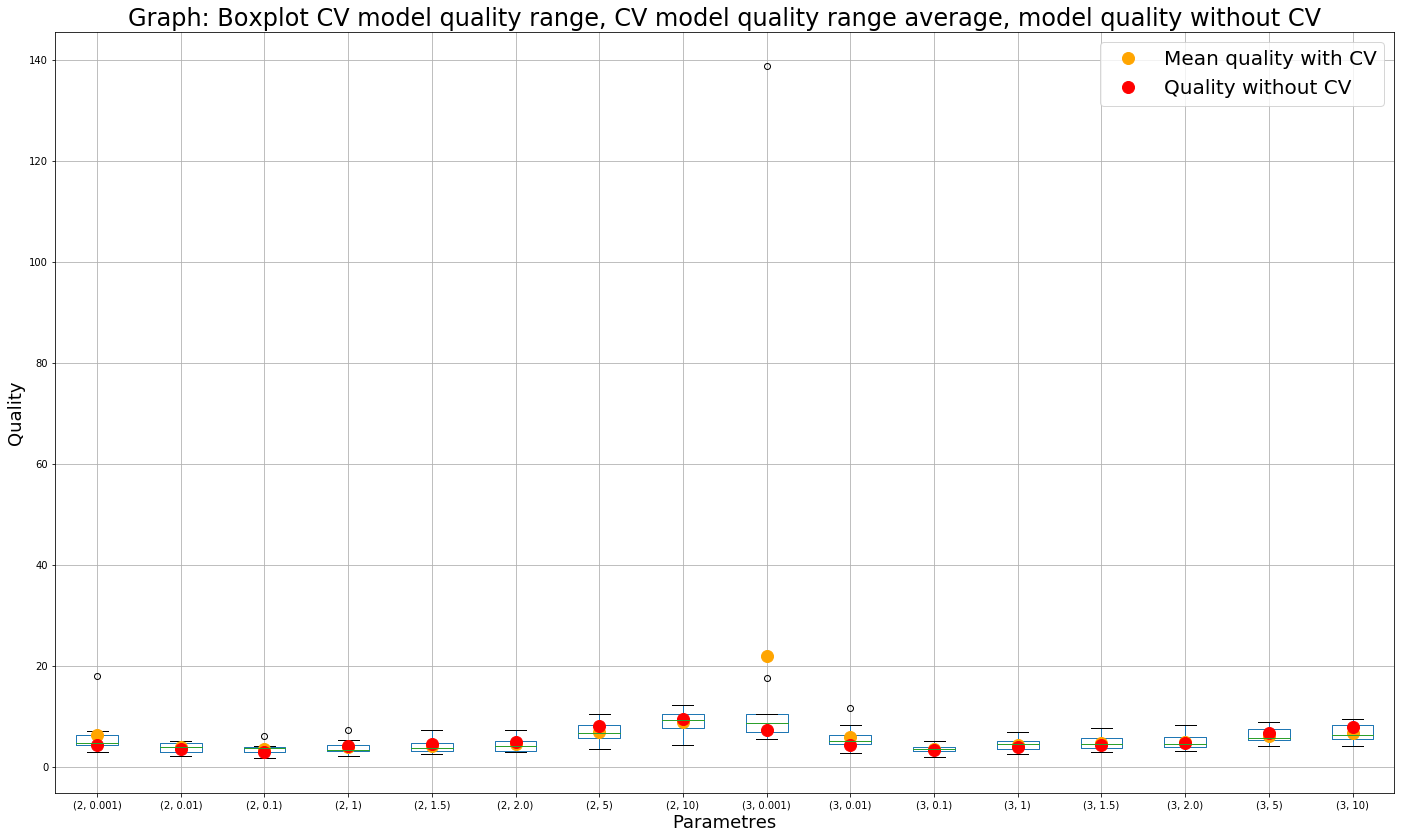

In [121]:
graph_for_quality(dataframe_cv, dataframe_noncv, name_model)

Мы наблюдаем, что при кросс-валидации, качество модели Lasso в целом ниже чем Ridge, но некоторые подвыборки показывают очень хороший результат, большинство - приемлемый результат и только несколько, как правило не более одной подвыборки очень плохой результат. 

На тестовой выборке качество получилось значительно лучше чем Ridge, оно сопоставимо с качеством лучших моделей решающих деревьев.

Это косвенно указывает на необходимость кластеризации данных перед анализом. Фиксируем результаты.

In [122]:
upgrade_best_models_dataframe_cv_2(best_models_dataframe_cv, dataframe_cv, cv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet,LinReg_L2_Poly,LinReg_L1_Poly
0,2.927,3.536,3.132,3.075,3.671,5.078,4.751,5.078,4.700,3.831,3.875
1,2.229,2.197,2.161,2.425,3.077,4.416,3.898,4.415,3.834,2.781,2.816
2,3.903,5.188,3.851,3.731,5.246,5.363,5.497,5.363,5.539,4.722,4.180
3,4.560,2.900,3.470,3.526,3.338,4.235,3.862,4.235,3.835,4.244,3.799
4,4.522,4.930,4.849,6.035,6.344,7.243,7.508,7.243,7.569,5.000,6.019
5,3.242,2.823,2.924,3.062,2.901,3.112,3.352,3.112,3.416,2.916,3.099
6,2.990,2.326,2.649,2.963,2.323,2.214,2.232,2.214,2.270,2.554,2.286
7,4.048,3.485,4.114,4.108,3.349,4.088,3.995,4.088,3.999,3.574,3.679
8,1.743,1.753,1.743,1.648,1.809,2.614,2.474,2.614,2.453,1.809,1.712
9,3.175,2.404,3.600,3.821,2.537,3.608,3.711,3.609,3.673,3.055,3.602


In [123]:
make_std_dataframe(dataframe_std, best_models_dataframe_cv, name_model)

Стандартное отклонение оценок качества лучших моделей на кросс-валидации:


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet,LinReg_L2_Poly,LinReg_L1_Poly
0,0.884,1.088,0.882,1.103,1.3,1.394,1.447,1.394,1.46,0.959,1.113


In [124]:
upgrade_best_models_dataframe_noncv(best_models_dataframe_noncv, dataframe_noncv, name_model)

Quality assessment of the best models dataframe


,GBR,GBR_sqrt,GBR_stoch,RF,RF_sqrt,Analyt_Solve,LinReg_L2_Ridge,LinReg_L1_Lasso,LinReg_ElasticNet,LinReg_L2_Poly,LinReg_L1_Poly
0,2.665,2.779,2.716,2.876,3.166,4.453,4.449,4.452,4.453,3.201,2.932


# Итоговое резюме
Давайте для наглядности построим график оценок качества лучших моделей по масштабированным признакам

Model quality assessment 
Model: LinReg_L1_Poly


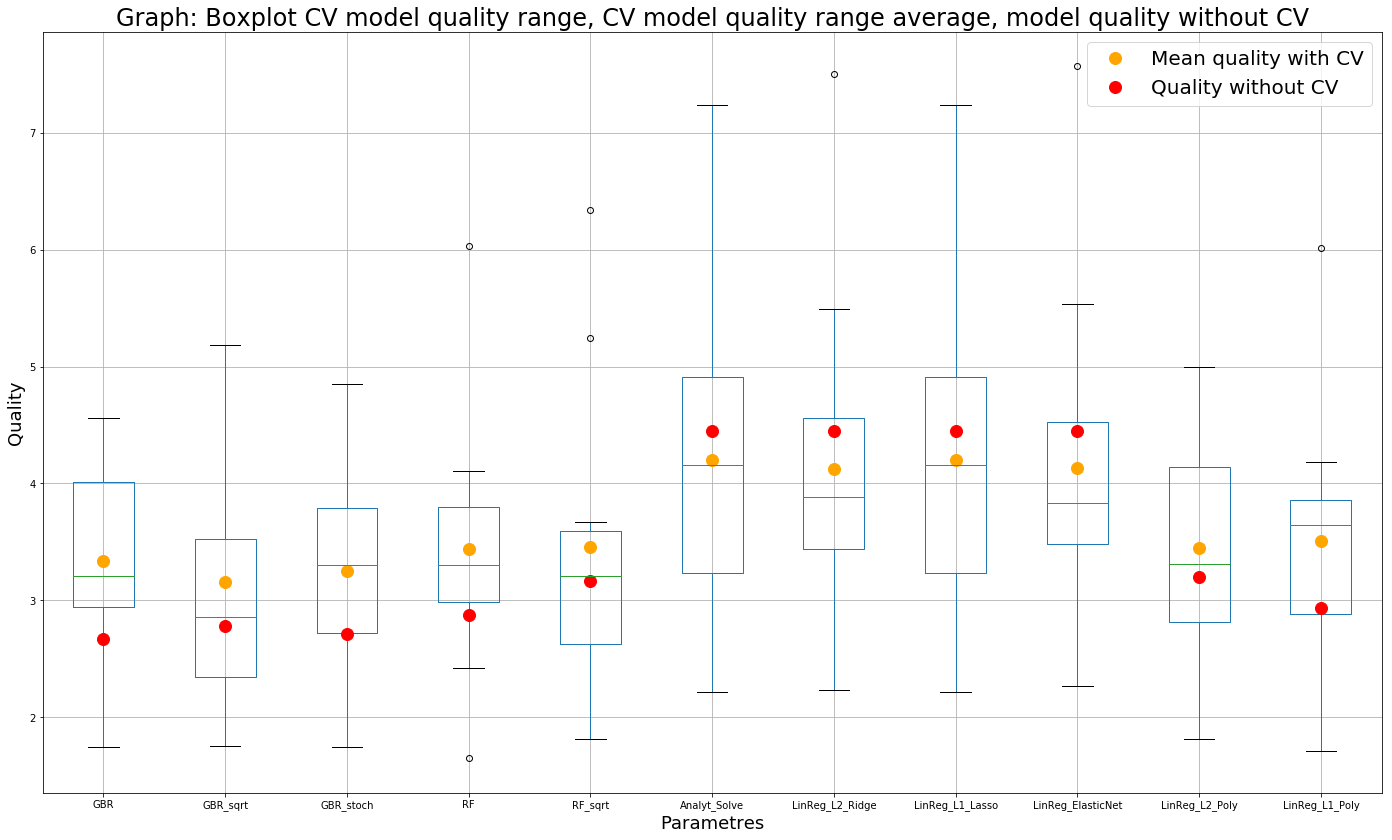

In [125]:
graph_for_quality(best_models_dataframe_cv, best_models_dataframe_noncv, name_model)

Чтобы не повторяться, не будем описывать лучшие модели. Они в целом не поменялись.

На что стоит обратить внимание:

1) Масштабирование ощутимо улучшает качество для линейных моделей, и немного на деревьях решений.

2) В целом линейные модели проигрывают в средних значениях качества и дисперсии оценок качества решающим деревьям, но использование полиномиальных признаков позволяет существенно сократить разрыв в качестве. При этом стоит отметить, что скорость обработки на линейных моделях значительно выше.

**Задел на будущее:** написать класс для проведения исследования, чтобы не множить код и побольше функций при формировании таблиц результатов или же это тоже метод самописного класса.